### 1.0 Import packages and adjust settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import seaborn as sns
import xarray as xr
xr.set_options(display_style='text'); # Show xarray.Dataset representation as text

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10}) # Set plot font size to 16pt

import numpy as np
import time
from scipy.spatial import cKDTree

from pykrige import OrdinaryKriging as OKpy
import tqdm
import os


os.chdir("../..")
import pandas as pd
import matplotlib as mpl

# OPENSENSE Sandbox tools 
# ToDo: Set link from local to github
import PWSpyqcFunctions as pws_pyqc
import statsmodels.api as sm

import Funcs as funcs
# Link to the data
main_dir = "Data/Clean_data/"


In [2]:
os.getcwd()

'c:\\Users\\arian\\OneDrive\\Documents\\cours\\M1S2\\design_gitlab'

PWSqc-QC specific settings 


In [3]:
# maximun distance (meters) for which the indicator correlation is calculated
max_distance = 50000

# Precentile threshold for indicator correlation 
prob=0.99

# todo: chekc if and where this is needed
show_plot = True

# minimum number of records (in hours) with values (here 2 months)
min_req_ppt_vals = 2*30*24 

### 1.1 Load the csv data files

In [4]:
# Automatic weather satation data from Oceau canton de genève
path_primary_network = os.path.join(main_dir, r"oceau_hour_after_april.csv")
path_primary_metadata = os.path.join(main_dir, r"Metadata_oceau.csv")   


# PWS hourly data from netatmo of the canton of geneve
path_pws_data = os.path.join(main_dir, r"pws_hourly_total.csv")   
path_pws_metadata = os.path.join(main_dir, r"metatablehour_tot.csv")

**&#8594;** each datasets consists of a metafile with coordinates and a data file with stations as columns and timestamps as rows (c.f. OPENSENSE White Paper)

**&#8594;** the Netatmo PWS data set used here is published by de [Vos (2019)](https://data.4tu.nl/articles/_/12703250/1)

**&#8594;** `pyqc.read_pcp_csv_file` and `read_metadata_csv_file` in the following code are functions based on `pandas.DataFrame` 

If you are familiar with python functions you can have a look at the file **PWSpyqcFunctions.py**

In [5]:
# read primary network 1
print('Reading first primary network data')
# pyqc.read_pcp_csv_file has 'latin-1' encoding in PWSpyqcFunctions.py
in_primary_pcp = pws_pyqc.read_pcp_csv_file(path_to_file=path_primary_network,
                           sep_type=',',
                           index_col=0)

# pyqc uses EPSG:25832, for Netherlands EPSG:28531 is used!
# Reads coordinate file and additionally coverts Lat/Lon to UTM 32
df_prim_coords, prim_coords_xy = pws_pyqc.read_metadata_csv_file(path_primary_metadata,
                                                           sep_type=',', index_col=0,)
df_prim_coords.index = in_primary_pcp.columns
# read pws data
print('Reading PWS data')
df_pws_pcp_hourly = pws_pyqc.read_pcp_csv_file(
        path_to_file=path_pws_data,
                           sep_type=',',
                           index_col=0)
    
df_pws_coords, pws_coords_xy = pws_pyqc.read_metadata_csv_file(
        path_to_file=path_pws_metadata,
                           sep_type=',',ID_index =True,
                           index_col=0)


Reading first primary network data
Reading PWS data


In [6]:
min_req_ppt_vals

1440

### 1.2 How do the data look like?

In [7]:
df_pws_coords

lon        lat              X             Y
ID                                                                 
05_00_00_00_03_84  6.362294  46.164563  296365.512320  5.115714e+06
05_00_00_00_04_44  6.094004  46.181375  275722.259758  5.118305e+06
05_00_00_00_0b_98  6.237484  46.191136  286833.072352  5.118994e+06
05_00_00_00_15_46  6.118505  46.147949  277478.249884  5.114523e+06
05_00_00_00_15_e6  6.002537  46.274946  269056.379038  5.128964e+06
...                     ...        ...            ...           ...
05_00_00_0b_35_48  6.033132  46.306054  271542.991684  5.132332e+06
05_00_00_0b_45_7c  6.238191  46.195931  286906.172832  5.119525e+06
05_00_00_0b_67_0c  6.140975  46.282925  279754.123891  5.129456e+06
05_00_00_0b_75_ea  6.056366  46.164401  272747.559762  5.116527e+06
05_00_00_0b_7a_a2  6.033414  46.306328  271565.892060  5.132361e+06

[265 rows x 4 columns]

In [8]:
# This shows the PWS data itself as described above
df_pws_pcp_hourly.head()

05_00_00_00_03_84  05_00_00_00_04_44  05_00_00_00_0b_98  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN              0.000                NaN   
2023-04-01 11:00:00                NaN              0.505                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN              0.101                NaN   

                     05_00_00_00_15_46  05_00_00_00_15_e6  05_00_00_00_17_e0  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   

                     05_00_00_00_17_f4  05_00_00_00_1d_5e  05_00_00_00_2c_4a  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                0.0   
2023-04-01 12:00:00                NaN              0.606                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   

                     05_00_00_00_30_20  ...  05_00_00_0a_c1_6e  \
time                                    ...                      
2023-04-01 09:00:00                NaN  ...                NaN   
2023-04-01 10:00:00                NaN  ...                NaN   
2023-04-01 11:00:00                NaN  ...                NaN   
2023-04-01 12:00:00                NaN  ...                NaN   
2023-04-01 13:00:00                NaN  ...                NaN   

                     05_00_00_0a_c5_2a  05_00_00_0a_ec_d8  05_00_00_0b_03_84  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   

                     05_00_00_0b_0c_0e  05_00_00_0b_35_48  05_00_00_0b_45_7c  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   

                     05_00_00_0b_67_0c  05_00_00_0b_75_ea  05_00_00_0b_7a_a2  
time                                                                          
2023-04-01 09:00:00                NaN                NaN                NaN  
2023-04-01 10:00:00                NaN                NaN                NaN  
2023-04-01 11:00:00                NaN                NaN                NaN  
2023-04-01 12:00:00                NaN                NaN                NaN  
2023-04-01 13:00:00                NaN                NaN                NaN  

[5 rows x 265 columns]

In [9]:
df_pws_pcp_hourly.describe()

05_00_00_00_03_84  05_00_00_00_04_44  05_00_00_00_0b_98  \
count          10.000000        2657.000000        2803.000000   
mean            0.171700           0.046224           0.216089   
std             0.362757           0.324221           2.102317   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             0.909000          10.201000          93.324000   

       05_00_00_00_15_46  05_00_00_00_15_e6  05_00_00_00_17_e0  \
count          13.000000        1622.000000         198.000000   
mean            0.481692           0.031944           0.575904   
std             1.706648           0.232891           1.358595   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.404000   
max             6.161000           4.444000           7.575000   

       05_00_00_00_17_f4  05_00_00_00_1d_5e  05_00_00_00_2c_4a  \
count         215.000000         155.000000          70.000000   
mean            0.074693           0.106865           0.028857   
std             0.336641           0.366742           0.206447   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             2.828000           2.828000           1.717000   

       05_00_00_00_30_20  ...  05_00_00_0a_c1_6e  05_00_00_0a_c5_2a  \
count         238.000000  ...           7.000000        1486.000000   
mean            0.204971  ...           0.909000           0.140353   
std             0.843670  ...           2.404988           2.734062   
min             0.000000  ...           0.000000           0.000000   
25%             0.000000  ...           0.000000           0.000000   
50%             0.000000  ...           0.000000           0.000000   
75%             0.000000  ...           0.000000           0.000000   
max            11.110000  ...           6.363000         103.525000   

       05_00_00_0a_ec_d8  05_00_00_0b_03_84  05_00_00_0b_0c_0e  \
count          36.000000        2846.000000                1.0   
mean            0.342278           0.139186                0.0   
std             0.563782           0.556821                NaN   
min             0.000000           0.000000                0.0   
25%             0.000000           0.000000                0.0   
50%             0.000000           0.000000                0.0   
75%             0.631250           0.000000                0.0   
max             1.818000           6.666000                0.0   

       05_00_00_0b_35_48  05_00_00_0b_45_7c  05_00_00_0b_67_0c  \
count         173.000000                6.0         196.000000   
mean            0.025688                0.0           0.036071   
std             0.133568                0.0           0.199525   
min             0.000000                0.0           0.000000   
25%             0.000000                0.0           0.000000   
50%             0.000000                0.0           0.000000   
75%             0.000000                0.0           0.000000   
max             1.212000                0.0           2.020000   

       05_00_00_0b_75_ea  05_00_00_0b_7a_a2  
count          49.000000               10.0  
mean            0.115429                0.0  
std             0.294463                0.0  
min             0.000000                0.0  
25%             0.000000                0.0  
50%             0.000000                0.0  
75%             0.000000                0.0  
max             1.414000

### 1.3 Plotting the data

### 1.3.1 Location of the stations

Plotting locations of all data


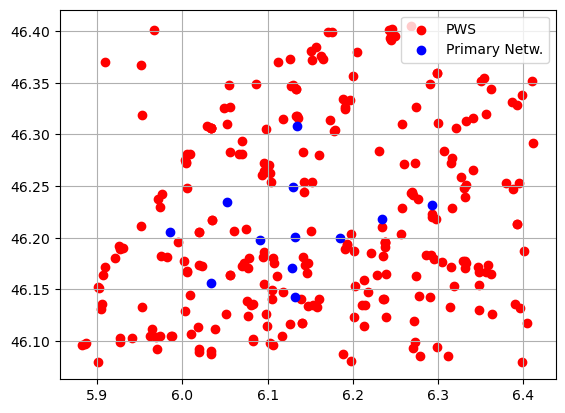

In [10]:
print('Plotting locations of all data')

pws_pyqc.plot_pws_prim_netz_loc(lon_pws=df_pws_coords.lon,
                       lat_pws=df_pws_coords.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat)

    


In [11]:
df_pws_coords.lon.min()

5.882286

In [12]:
def find_corners(lon_pws, lon_prim1,lat_pws,lat_prim1 ):
    llcrnrlon = min(lon_pws.min(),lon_prim1.min())
    llcrnrlat = min(lat_pws.min(),lat_prim1.min())
    urcrnrlon = max(lon_pws.max(),lon_prim1.max())
    urcrnrlat = max(lat_pws.max(),lat_prim1.max())
    print(llcrnrlon, llcrnrlat, urcrnrlon,urcrnrlat )
    return llcrnrlon, llcrnrlat, urcrnrlon,urcrnrlat 


Plotting locations of data in and around Genève


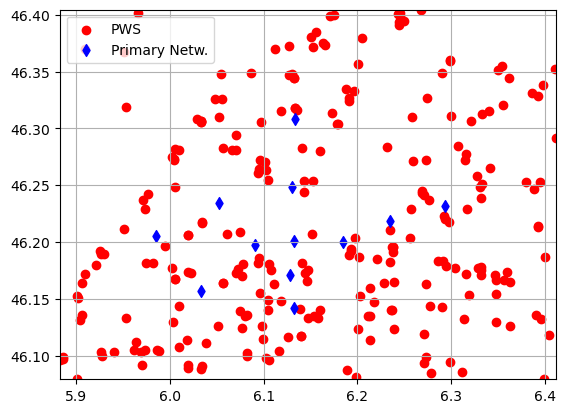

In [13]:
print('Plotting locations of data in and around Genève')

pws_pyqc.plot_pws_prim_netz_loc_AMS(lon_pws=df_pws_coords.lon,
                                    lat_pws=df_pws_coords.lat,
                                    lon_prim1=df_prim_coords.lon,
                                    lat_prim1=df_prim_coords.lat)

### 1.3.2 Plotting the PWS data

<Axes: xlabel='time', ylabel='mm'>

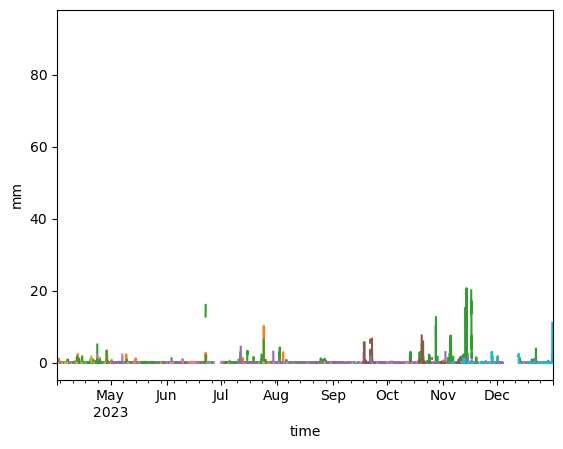

In [14]:
# Plotting first 10 stations
df_pws_pcp_hourly.iloc[:,:10].plot(legend=False, ylabel='mm')

### Let's plot some individual stations

This does not really make sense with 134 stations.

+ What is the first thing we can observe here?

In [15]:
#we search the station which have most data
df_pws_pcp_hourly.count().idxmax()

'05_00_00_01_98_2c'

In [16]:
print(f"percentage of nan in the df {df_pws_pcp_hourly.isna().sum().sum()/df_pws_pcp_hourly.size}")

percentage of nan in the df 0.6998640226953278


<Axes: title={'center': 'PWS 05_00_00_01_98_2c'}, xlabel='time', ylabel='mm'>

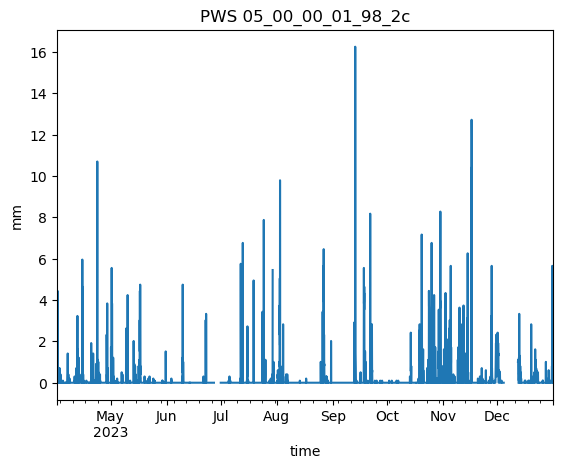

In [17]:
# PWS station ams18
df_pws_pcp_hourly['05_00_00_01_98_2c'].plot(ylabel='mm', title='PWS 05_00_00_01_98_2c')


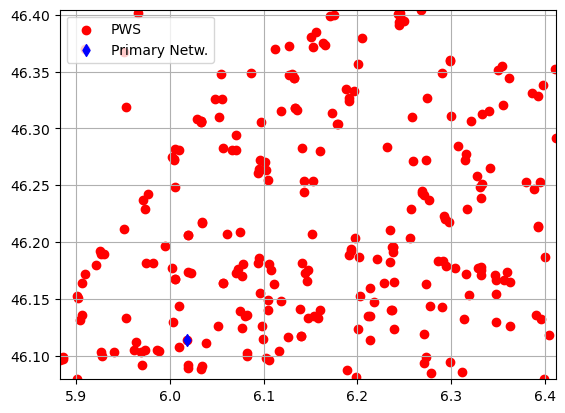

In [18]:
pws_pyqc.plot_pws_prim_netz_loc_AMS(lon_pws=df_pws_coords.lon,
                                    lat_pws=df_pws_coords.lat,
                                    lon_prim1=df_pws_coords.loc['05_00_00_01_98_2c'].lon,
                                    lat_prim1=df_pws_coords.loc['05_00_00_01_98_2c'].lat)

## 2. First PWSpy-QC step: Indicator correlation based filter
The fist QC-filter of PWS-pyqc is based on indicator correlation patterns of the primary network (cf. [Bárdossy et al. 2021](https://doi.org/10.5194/hess-25-583-2021)). First, the data of the primary network are converted to 1 and 0 based on a threshhold, in this case the 99%-percentile. All values above this percentile are 1, all below 0. This indicator correaltion of the primay stations has a spatial structure, i.e. the correlation decreases with increasing distance

Calculating indicator correlation


100%|██████████| 264/264 [00:09<00:00, 28.22it/s] 


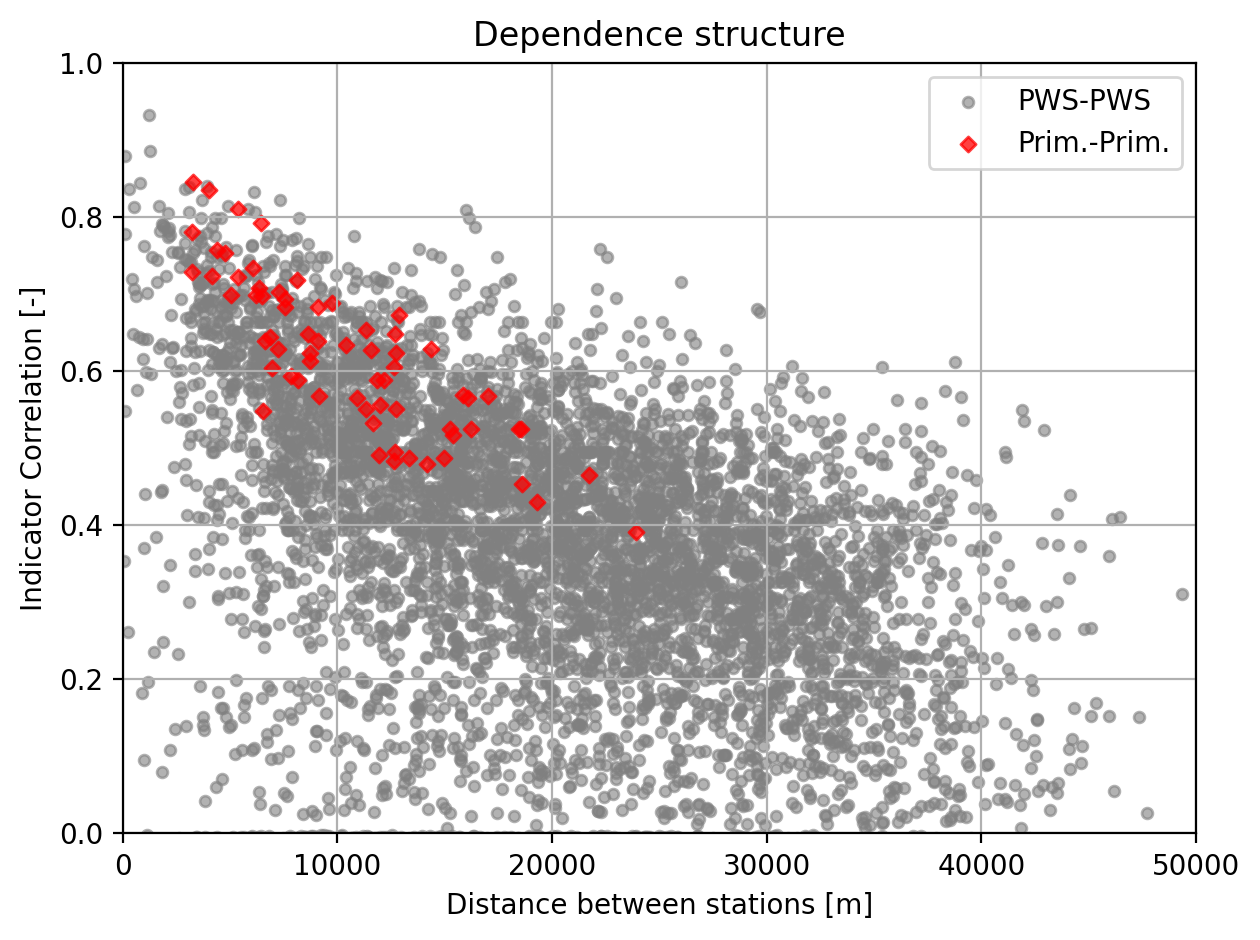

In [19]:
# PLOT indicator correlation values different networks
# calculate indicator correlation primary network
print('Calculating indicator correlation')

dist_prim, corr_prim = pws_pyqc.calc_indic_corr_all_stns(min_req_ppt_vals =min_req_ppt_vals,
                             coords_stns_xy=prim_coords_xy,
                             pcp_vals=in_primary_pcp.values, prob=0.99)


# claculate indicator correlation PWS-PWS
dist_pws, corr_pws = pws_pyqc.calc_indic_corr_all_stns(min_req_ppt_vals =min_req_ppt_vals,
                    coords_stns_xy=pws_coords_xy,
                         pcp_vals=df_pws_pcp_hourly.values)

# plot indicator correlations
pws_pyqc.plot_indic_coor(dist_prim=dist_prim,
                corr_prim=corr_prim,
                dist_pws=dist_pws,
               corr_pws=corr_pws)

As can be seen in the plot above, the primary stations have a certain dependence sturcture over distance. Most of the PWS as well, but there are also some PWS which do not follow this structure. When the indicator corrleation of a PWS next to a primary station is low, then it is likley that the PWS data are faulty. The first QC-filter pf PWS-pyqc now removes all PWS which do not show indicator correlations similiar to that of the reference data (primary stations).

100%|██████████| 264/264 [00:07<00:00, 36.92it/s]


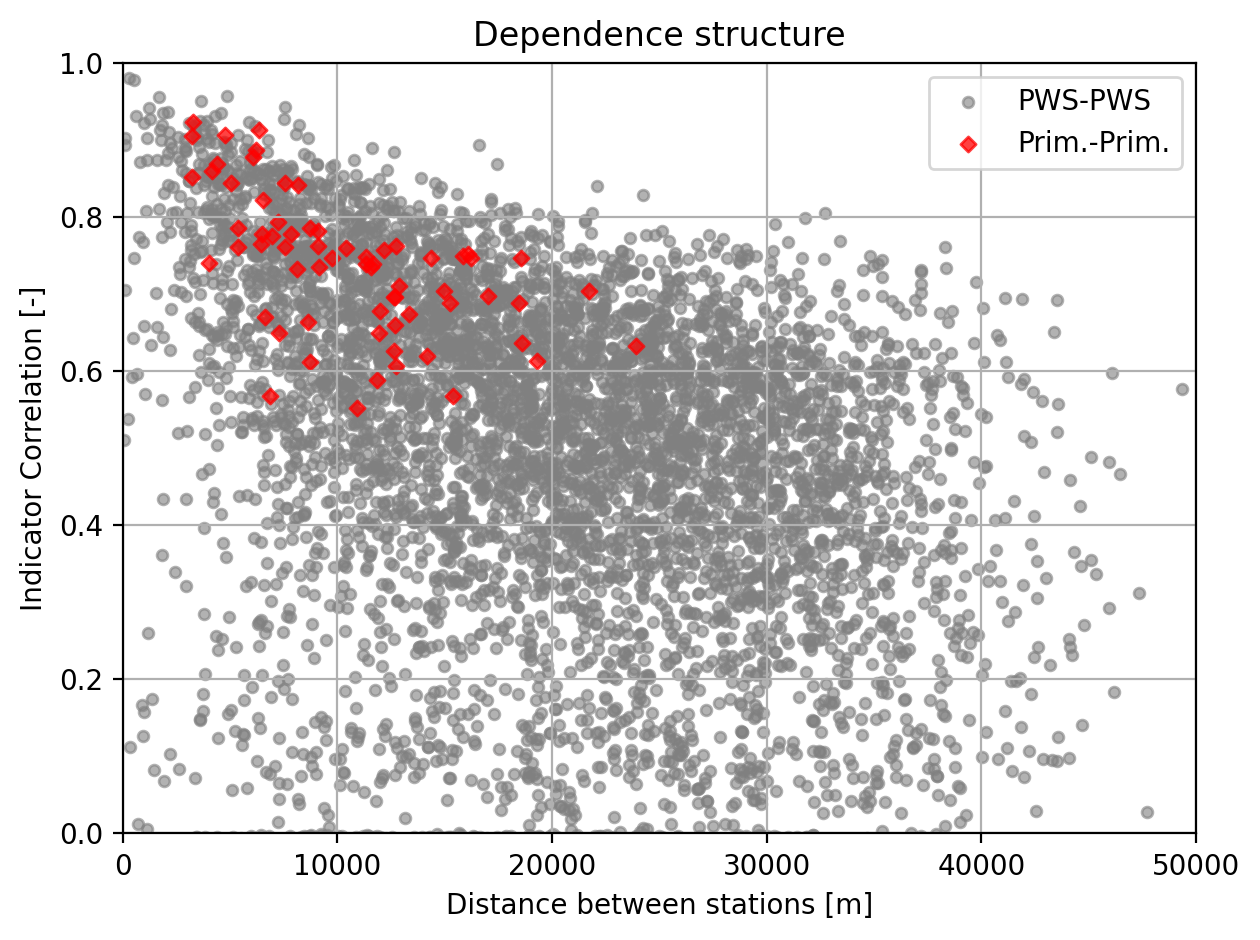

In [20]:
dist_all_prim, corr_all_prim = pws_pyqc.calc_indic_corr_all_data(min_req_ppt_vals =min_req_ppt_vals,
                             coords_stns_xy=prim_coords_xy,
                             pcp_vals=in_primary_pcp.values)

dist__all_pws, corr__all_pws = pws_pyqc.calc_indic_corr_all_data(min_req_ppt_vals =min_req_ppt_vals,
                             coords_stns_xy=pws_coords_xy,
                            pcp_vals=df_pws_pcp_hourly.values)


pws_pyqc.plot_indic_coor(dist_prim=dist_all_prim,
                corr_prim=corr_all_prim,
                dist_pws=dist__all_pws,
               corr_pws=corr__all_pws)


### Applying the Indicator correlation based filter

100%|██████████| 265/265 [00:21<00:00, 12.34it/s]


Total Accepted 99 265
1452


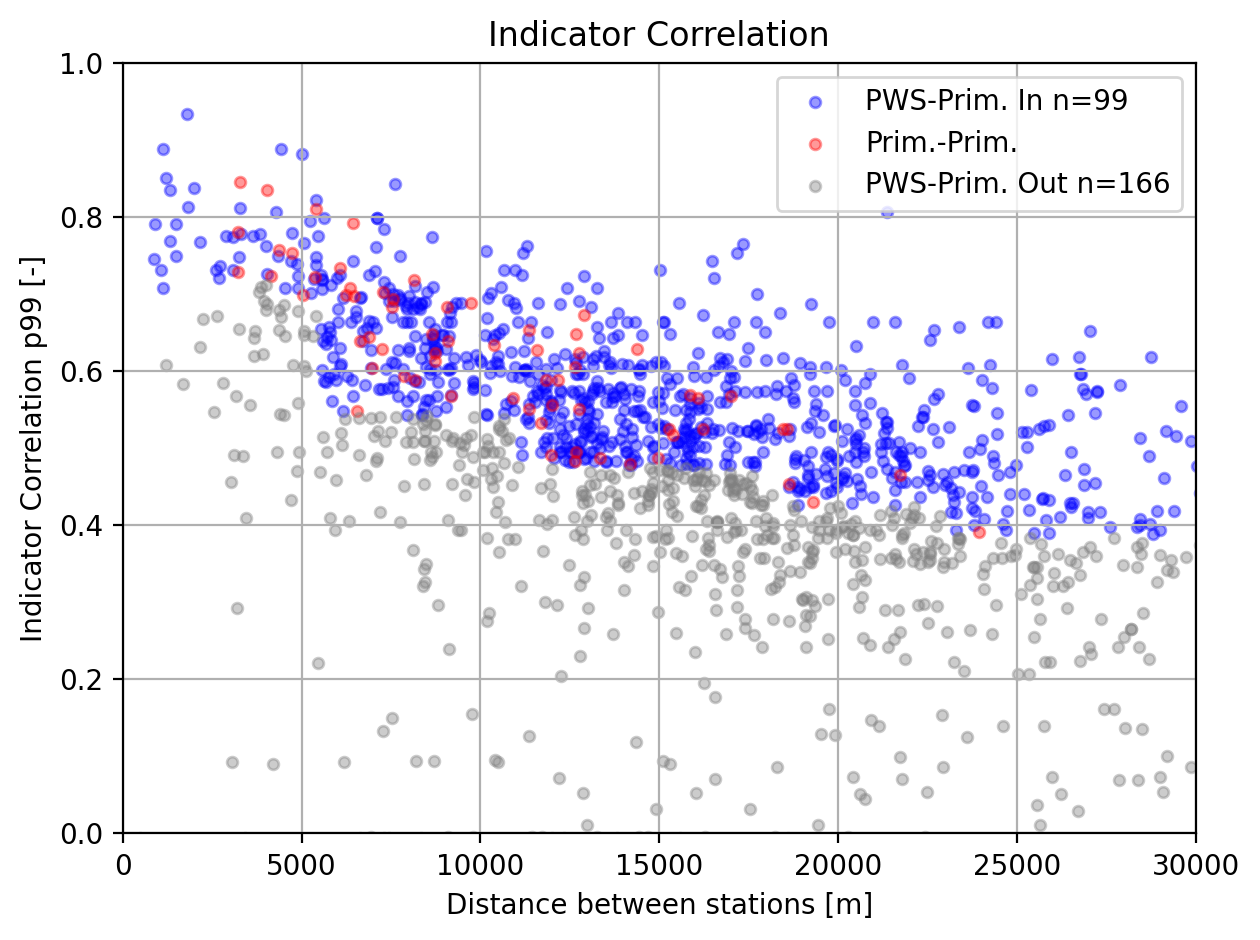

In [21]:
# apply indicator filter (using primary stations 2)

#prc for precipitation
#dwd for primary weather station
stn_in   = pws_pyqc.indicator_filter(xy_net=pws_coords_xy,
                 prc_net=df_pws_pcp_hourly,
                 xy_dwd=prim_coords_xy,
                 prc_dwd=in_primary_pcp,
                     prob=0.99, max_distance=max_distance,
                     min_req_ppt_vals=min_req_ppt_vals, show_plot=True,
                     fn_figure='Indicator Correlation',
                     save_folder=None,
                    tolerance=.99)

# what data type is stn_in
# Was ist tolerance? (1 muss größer als min) Parameter zum aus probieren

100%|██████████| 265/265 [00:23<00:00, 11.09it/s]


Total Accepted 99 265
1452


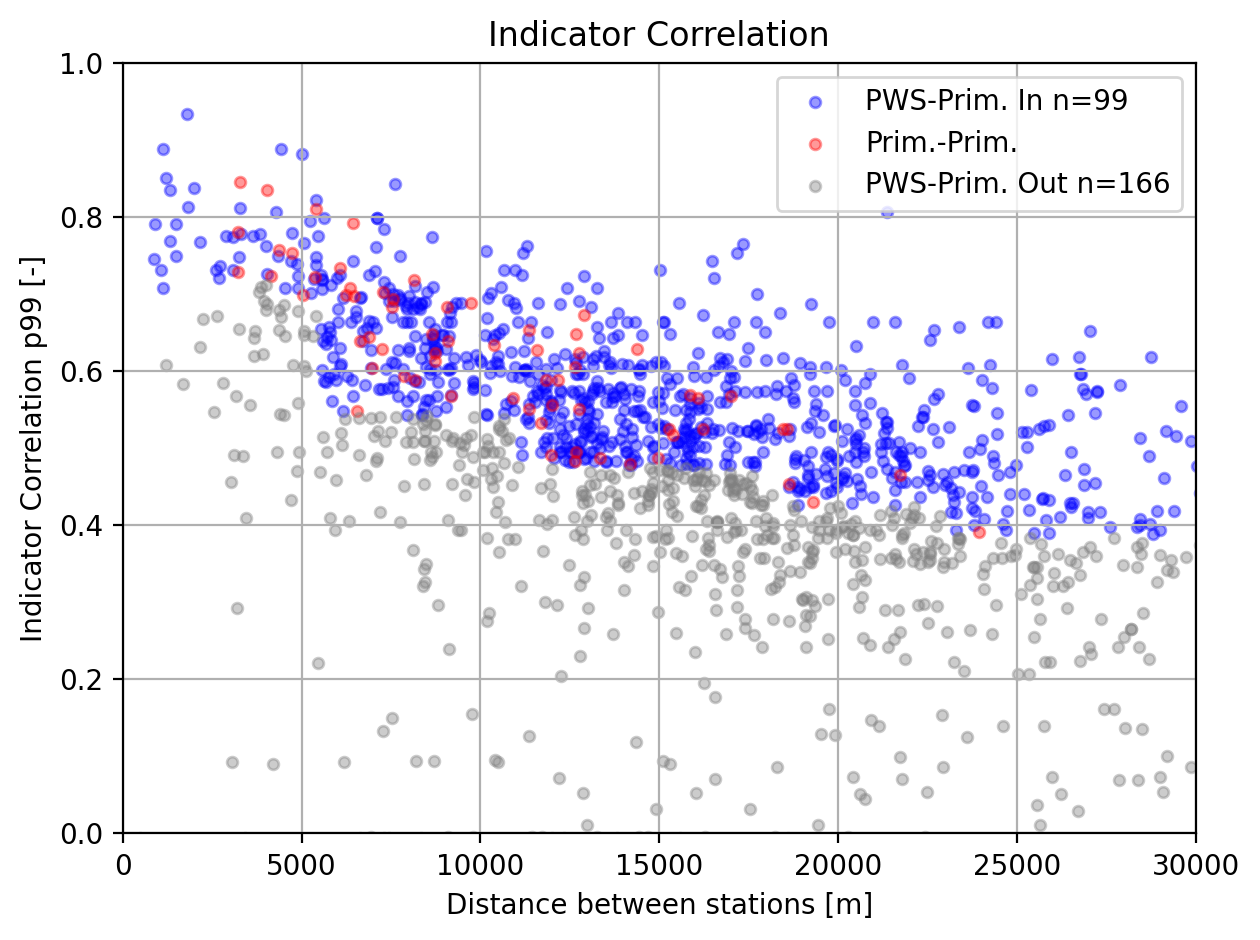

100%|██████████| 11/11 [00:00<00:00, 127.03it/s]


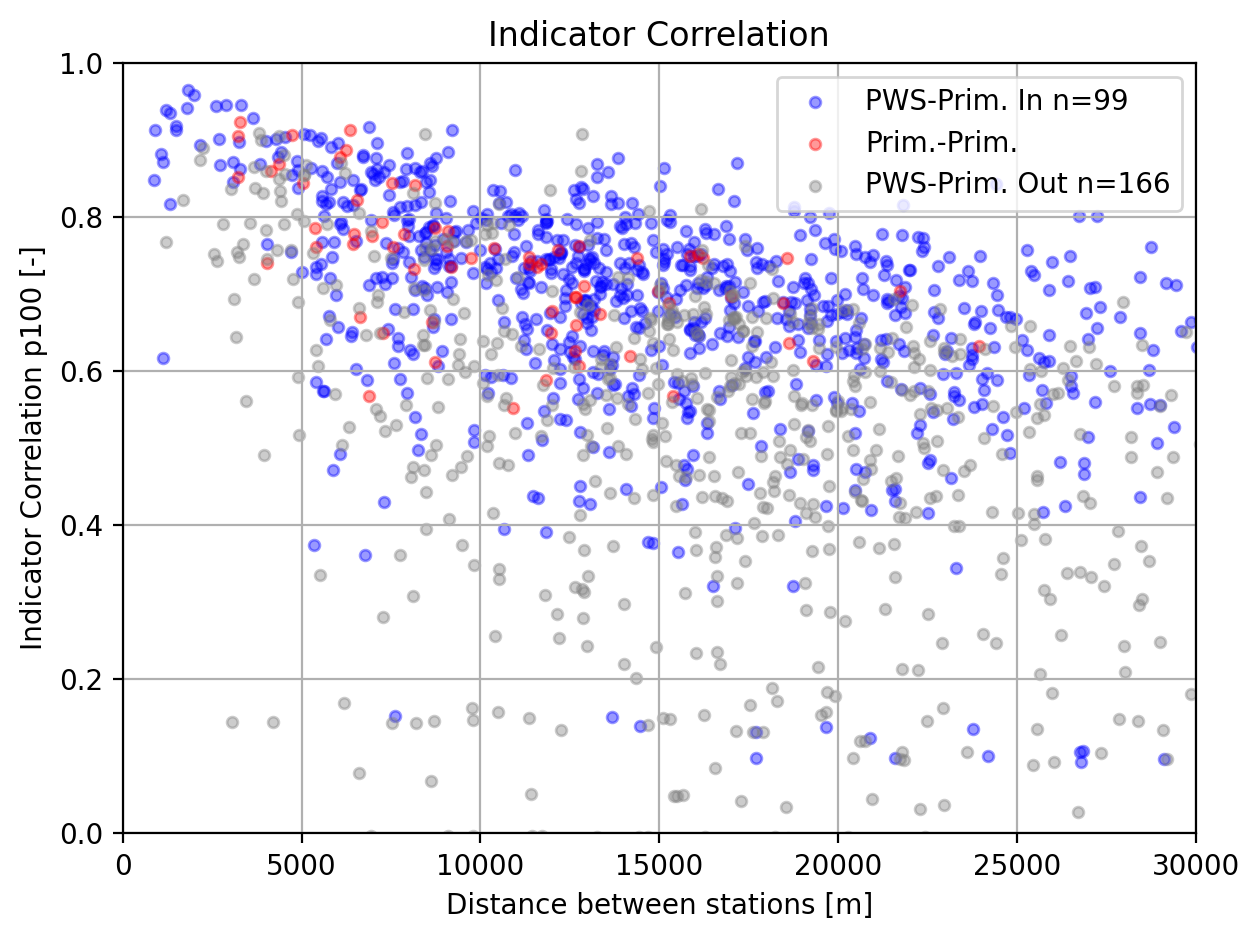

In [22]:
#Cette fonction a été ajoute dans le cadre du design project afin de comparer les correlations des sseries temporelles
#aux correlations de rang
_  = pws_pyqc.indicator_filter_two(xy_net=pws_coords_xy,
                 prc_net=df_pws_pcp_hourly,
                 xy_dwd=prim_coords_xy,
                 prc_dwd=in_primary_pcp,
                     prob=0.99, max_distance=max_distance,
                     min_req_ppt_vals=min_req_ppt_vals, show_plot=True,
                     fn_figure='Indicator Correlation',
                     save_folder=None, show_corr_all =True,
                    tolerance=.99)

### Analyse sur les stations acceptées

In [23]:
# list the accepted stations
pws_ids_accepted = df_pws_pcp_hourly.columns[np.where(stn_in==True)]
accepted_pws = df_pws_pcp_hourly[df_pws_pcp_hourly.columns.intersection(pws_ids_accepted)]
accepted_coordinates = df_pws_coords.loc[pws_ids_accepted,:]
print(f"Plus petit nombre de donnees sur les stations acceptees {accepted_pws.count().min()}")
print(f"Nombre moyen de donnees sur les stations acceptees {accepted_pws.count().mean()}")
# convert to long (tidy) form
accepted_melt = accepted_pws.melt( var_name='station', value_name='vals')
primary_melt = in_primary_pcp.melt( var_name='station', value_name='vals')
pws_melt = df_pws_pcp_hourly.melt( var_name='station', value_name='vals')

Plus petit nombre de donnees sur les stations acceptees 1486
Nombre moyen de donnees sur les stations acceptees 4010.070707070707


Localisation des stations acceptées à Genève


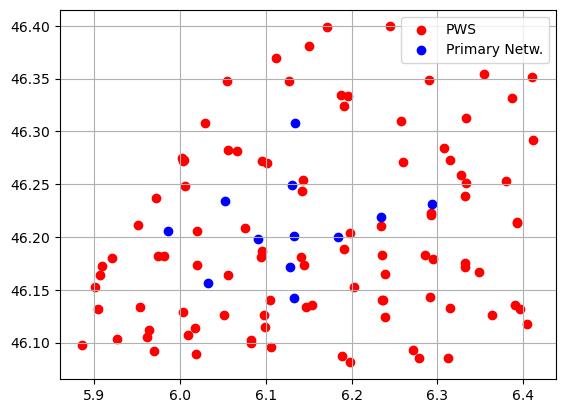

In [24]:
print('Localisation des stations acceptées à Genève')

pws_pyqc.plot_pws_prim_netz_loc(lon_pws=accepted_coordinates.lon,
                       lat_pws=accepted_coordinates.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat)

##### Diagramme quantile-quantile

Diagramme quantile-quantile des distributions des stations Netatmo brutes face aux distributions de l'Oceau

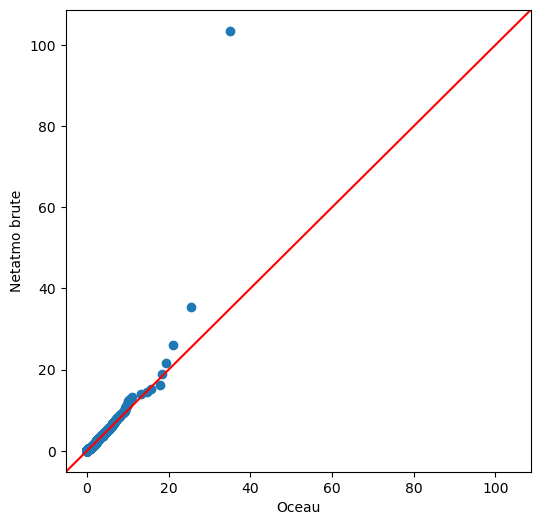

In [25]:

funcs.QQplot(primary_melt.vals.dropna(),pws_melt.vals.dropna(),50000,label_2_sample= "Netatmo brute")


Diagramme Quantile-quantile des stations acceptées

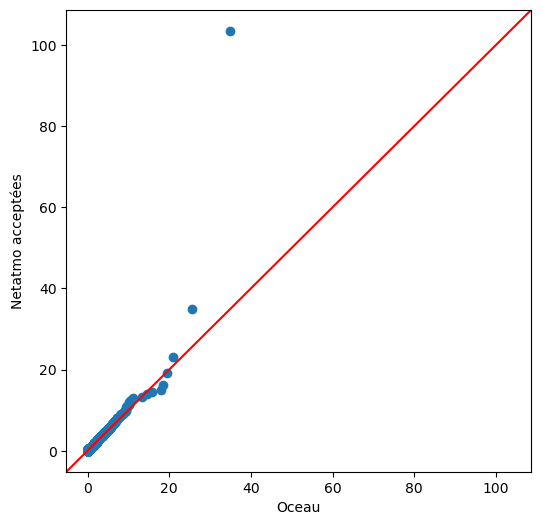

In [26]:
 
funcs.QQplot(primary_melt.vals.dropna(),accepted_melt.vals.dropna(),50000,label_2_sample= "Netatmo acceptées")


In [27]:
print(f"le pourcentage de Nan dans les stations acceptées est de {accepted_melt.vals.isna().sum()/accepted_melt.vals.shape[0]}")

le pourcentage de Nan dans les stations acceptées est de 0.3915838708738117


In [28]:
print(f"le pourcentage de 0 dans les stations acceptées est de {funcs.compute_0_percent(accepted_melt.vals.dropna())}")


le pourcentage de 0 dans les stations acceptées est de 0.8822963397708296


In [29]:
print(f"le pourcentage de 0 dans les stations primaires est de {funcs.compute_0_percent(primary_melt.vals.dropna())}")

le pourcentage de 0 dans les stations primaires est de 0.8854166666666666


##### Les séries temporelles

c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Temps')

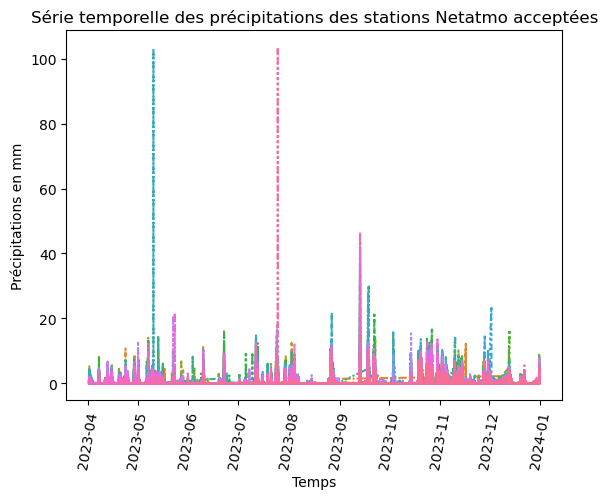

In [30]:
sns.lineplot(data = accepted_pws)
plt.legend('',frameon=False)
plt.xticks(rotation=80) 
plt.title("Série temporelle des précipitations des stations Netatmo acceptées")
plt.ylabel("Précipitations en mm")
plt.xlabel("Temps")

c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Temps')

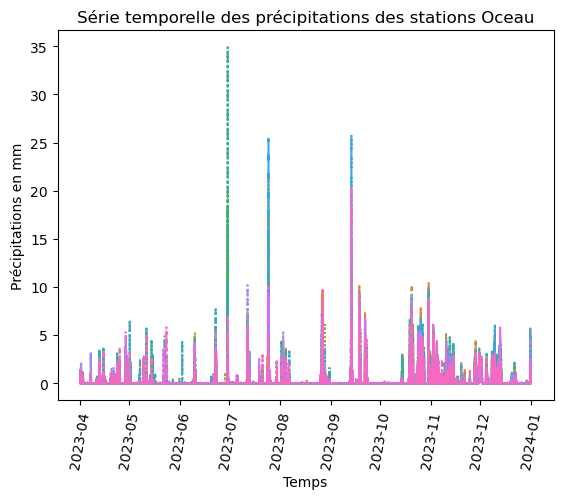

In [31]:
sns.lineplot(data = in_primary_pcp)
plt.legend('',frameon=False)
plt.xticks(rotation=80) 
plt.title("Série temporelle des précipitations des stations Oceau")
plt.ylabel("Précipitations en mm")
plt.xlabel("Temps")

In [32]:
stat_primary =in_primary_pcp.copy(deep=True)
stat_accepted_pws = accepted_pws.copy(deep=True)

stat_primary['mean'] = in_primary_pcp.mean(axis=1, numeric_only=True, skipna=True)
stat_accepted_pws["mean"] = accepted_pws.mean(axis=1, numeric_only=True, skipna=True)

c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

Text(0, 0.5, 'précipitation moyenne en mm')

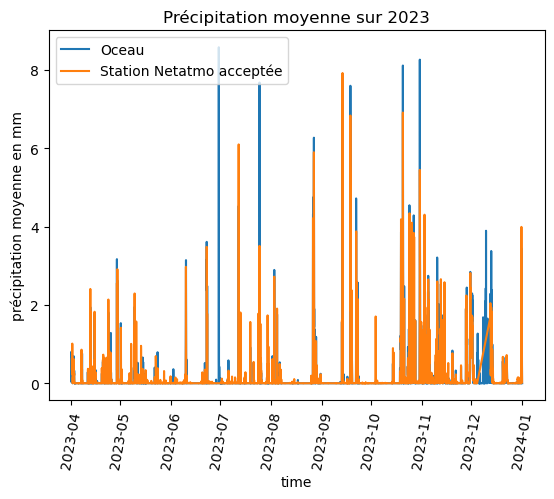

In [33]:
stat_primary =in_primary_pcp.copy(deep=True)
stat_accepted_pws = accepted_pws.copy(deep=True)

stat_primary['mean'] = in_primary_pcp.mean(axis=1, numeric_only=True, skipna=True)
stat_accepted_pws["mean"] = accepted_pws.mean(axis=1, numeric_only=True, skipna=True)

sns.lineplot(data = stat_primary, x= "time", y = "mean", label = "Oceau")
sns.lineplot(data = stat_accepted_pws, x= "time", y = "mean", label = "Station Netatmo acceptée")
plt.xticks(rotation=80) 
plt.title("Précipitation moyenne sur 2023")
plt.ylabel("précipitation moyenne en mm")

## 3. Bias Correction

PWS can over- or undererstimate the precepitation compared to a professional refernce station (panel b) in figure below). The reasons herefore are mayfold (c.f. Introduction). The goal is to correct the PWS distribution function usind the distribution function of neighbouring primary network stations. For more details see [Bárdossy et al. (2021)](https://doi.org/10.5194/hess-25-583-2021)

<img src="./pics/bias.png" alt="drawing" width="800"/>


### Basic Scheme of the PWS-pyqc Bias Correction


<img src="./pics/bias_correction.png" alt="drawing" width="400"/>

In [34]:
# run bias corrections for all stations - this takes a while (~lunch break)
# hint: you can save the output dataframe and work with it afterwards
df_pws_bias_corrected = pws_pyqc.bias_corr_pws_cdf(df_pws_raw=df_pws_pcp_hourly,
                        pws_ids_accepted=pws_ids_accepted,
                        df_pws_coords=df_pws_coords,                            
                        prim_coords_xy_2=prim_coords_xy,
                        in_primary_pcp_2=in_primary_pcp,
                        df_prim_coords_2=df_prim_coords,
                        nstns_correct=len(pws_ids_accepted),
                        plot_figures=False,
                        ppt_min_thr_0_vals=0.1,  # below it all values get p0/2
                        min_qt_to_correct=0.9)

100%|██████████| 12/12 [00:00<00:00, 120.13it/s]


Done converting primary network precipitaiton to quantile
Correcting  05_00_00_00_04_44 :  0 / 99
PWS DF shape to correct:  191


100%|██████████| 191/191 [00:02<00:00, 70.55it/s] 


Needed time (s) 2.76
Correcting  05_00_00_00_15_e6 :  1 / 99
PWS DF shape to correct:  74


100%|██████████| 74/74 [00:01<00:00, 47.57it/s]


Needed time (s) 1.58
Correcting  05_00_00_00_79_dc :  2 / 99
PWS DF shape to correct:  587


100%|██████████| 587/587 [00:12<00:00, 48.85it/s]


Needed time (s) 12.04
Correcting  05_00_00_00_97_94 :  3 / 99
PWS DF shape to correct:  408


100%|██████████| 408/408 [00:08<00:00, 48.42it/s]


Needed time (s) 8.45
Correcting  05_00_00_00_bf_2a :  4 / 99
PWS DF shape to correct:  442


100%|██████████| 442/442 [00:08<00:00, 49.32it/s]


Needed time (s) 8.98
Correcting  05_00_00_00_e2_44 :  5 / 99
PWS DF shape to correct:  97


100%|██████████| 97/97 [00:02<00:00, 45.49it/s]


Needed time (s) 2.15
Correcting  05_00_00_00_ec_32 :  6 / 99
PWS DF shape to correct:  332


100%|██████████| 332/332 [00:06<00:00, 48.30it/s]


Needed time (s) 6.89
Correcting  05_00_00_00_f1_ec :  7 / 99
PWS DF shape to correct:  211


100%|██████████| 211/211 [00:04<00:00, 49.10it/s]


Needed time (s) 4.32
Correcting  05_00_00_01_44_9a :  8 / 99
PWS DF shape to correct:  184


100%|██████████| 184/184 [00:03<00:00, 46.20it/s]


Needed time (s) 4.0
Correcting  05_00_00_01_98_2c :  9 / 99
PWS DF shape to correct:  627


100%|██████████| 627/627 [00:12<00:00, 48.98it/s]


Needed time (s) 12.85
Correcting  05_00_00_01_99_7e :  10 / 99
PWS DF shape to correct:  62


100%|██████████| 62/62 [00:01<00:00, 47.30it/s]


Needed time (s) 1.34
Correcting  05_00_00_01_9a_fe :  11 / 99
PWS DF shape to correct:  77


100%|██████████| 77/77 [00:01<00:00, 47.92it/s]


Needed time (s) 1.62
Correcting  05_00_00_01_a0_8c :  12 / 99
PWS DF shape to correct:  140


100%|██████████| 140/140 [00:02<00:00, 48.11it/s]


Needed time (s) 2.93
Correcting  05_00_00_01_ac_ee :  13 / 99
PWS DF shape to correct:  316


100%|██████████| 316/316 [00:06<00:00, 48.95it/s]


Needed time (s) 6.48
Correcting  05_00_00_01_d7_ac :  14 / 99
PWS DF shape to correct:  541


100%|██████████| 541/541 [00:10<00:00, 50.12it/s]


Needed time (s) 10.82
Correcting  05_00_00_02_04_92 :  15 / 99
PWS DF shape to correct:  380


100%|██████████| 380/380 [00:07<00:00, 50.55it/s]


Needed time (s) 7.55
Correcting  05_00_00_02_36_1e :  16 / 99
PWS DF shape to correct:  566


100%|██████████| 566/566 [00:11<00:00, 48.99it/s]


Needed time (s) 11.58
Correcting  05_00_00_02_58_84 :  17 / 99
PWS DF shape to correct:  305


100%|██████████| 305/305 [00:06<00:00, 50.13it/s]


Needed time (s) 6.11
Correcting  05_00_00_02_a7_e2 :  18 / 99
PWS DF shape to correct:  407


100%|██████████| 407/407 [00:08<00:00, 48.97it/s]


Needed time (s) 8.34
Correcting  05_00_00_02_d5_da :  19 / 99
PWS DF shape to correct:  494


100%|██████████| 494/494 [00:10<00:00, 48.19it/s]


Needed time (s) 10.28
Correcting  05_00_00_02_e9_4c :  20 / 99
PWS DF shape to correct:  481


100%|██████████| 481/481 [00:10<00:00, 46.86it/s]


Needed time (s) 10.29
Correcting  05_00_00_02_f3_fe :  21 / 99
PWS DF shape to correct:  172


100%|██████████| 172/172 [00:03<00:00, 48.80it/s]


Needed time (s) 3.55
Correcting  05_00_00_03_01_d0 :  22 / 99
PWS DF shape to correct:  463


100%|██████████| 463/463 [00:09<00:00, 47.72it/s]


Needed time (s) 9.73
Correcting  05_00_00_03_03_e6 :  23 / 99
PWS DF shape to correct:  612


100%|██████████| 612/612 [00:12<00:00, 47.87it/s]


Needed time (s) 12.82
Correcting  05_00_00_03_09_7c :  24 / 99
PWS DF shape to correct:  454


100%|██████████| 454/454 [00:06<00:00, 71.43it/s] 


Needed time (s) 6.38
Correcting  05_00_00_03_13_fe :  25 / 99
PWS DF shape to correct:  587


100%|██████████| 587/587 [00:03<00:00, 148.82it/s]


Needed time (s) 3.95
Correcting  05_00_00_03_35_7c :  26 / 99
PWS DF shape to correct:  575


100%|██████████| 575/575 [00:04<00:00, 141.17it/s]


Needed time (s) 4.1
Correcting  05_00_00_03_4b_a6 :  27 / 99
PWS DF shape to correct:  583


100%|██████████| 583/583 [00:04<00:00, 143.78it/s]


Needed time (s) 4.06
Correcting  05_00_00_03_8c_74 :  28 / 99
PWS DF shape to correct:  351


100%|██████████| 351/351 [00:02<00:00, 141.57it/s]


Needed time (s) 2.5
Correcting  05_00_00_04_03_e6 :  29 / 99
PWS DF shape to correct:  573


100%|██████████| 573/573 [00:04<00:00, 139.17it/s]


Needed time (s) 4.13
Correcting  05_00_00_04_71_5a :  30 / 99
PWS DF shape to correct:  334


100%|██████████| 334/334 [00:02<00:00, 146.50it/s]


Needed time (s) 2.3
Correcting  05_00_00_04_74_1e :  31 / 99
PWS DF shape to correct:  164


100%|██████████| 164/164 [00:01<00:00, 154.60it/s]


Needed time (s) 1.08
Correcting  05_00_00_04_93_10 :  32 / 99
PWS DF shape to correct:  78


100%|██████████| 78/78 [00:00<00:00, 141.70it/s]


Needed time (s) 0.56
Correcting  05_00_00_04_c3_32 :  33 / 99
PWS DF shape to correct:  534


100%|██████████| 534/534 [00:03<00:00, 142.38it/s]


Needed time (s) 3.77
Correcting  05_00_00_04_f6_20 :  34 / 99
PWS DF shape to correct:  542


100%|██████████| 542/542 [00:03<00:00, 140.55it/s]


Needed time (s) 3.87
Correcting  05_00_00_05_11_66 :  35 / 99
PWS DF shape to correct:  368


100%|██████████| 368/368 [00:02<00:00, 144.04it/s]


Needed time (s) 2.56
Correcting  05_00_00_05_11_bc :  36 / 99
PWS DF shape to correct:  534


100%|██████████| 534/534 [00:03<00:00, 142.56it/s]


Needed time (s) 3.76
Correcting  05_00_00_05_18_c4 :  37 / 99
PWS DF shape to correct:  352


100%|██████████| 352/352 [00:02<00:00, 142.06it/s]


Needed time (s) 2.49
Correcting  05_00_00_05_2b_ac :  38 / 99
PWS DF shape to correct:  414


100%|██████████| 414/414 [00:02<00:00, 147.68it/s]


Needed time (s) 2.8
Correcting  05_00_00_05_3c_8e :  39 / 99
PWS DF shape to correct:  533


100%|██████████| 533/533 [00:03<00:00, 145.00it/s]


Needed time (s) 3.7
Correcting  05_00_00_05_4c_f4 :  40 / 99
PWS DF shape to correct:  475


100%|██████████| 475/475 [00:03<00:00, 141.05it/s]


Needed time (s) 3.39
Correcting  05_00_00_05_57_c4 :  41 / 99
PWS DF shape to correct:  114


100%|██████████| 114/114 [00:00<00:00, 147.11it/s]


Needed time (s) 0.79
Correcting  05_00_00_05_66_c8 :  42 / 99
PWS DF shape to correct:  484


100%|██████████| 484/484 [00:03<00:00, 145.23it/s]


Needed time (s) 3.33
Correcting  05_00_00_05_69_00 :  43 / 99
PWS DF shape to correct:  399


100%|██████████| 399/399 [00:02<00:00, 137.01it/s]


Needed time (s) 2.92
Correcting  05_00_00_05_88_6c :  44 / 99
PWS DF shape to correct:  439


100%|██████████| 439/439 [00:03<00:00, 143.02it/s]


Needed time (s) 3.08
Correcting  05_00_00_05_fd_96 :  45 / 99
PWS DF shape to correct:  173


100%|██████████| 173/173 [00:01<00:00, 126.52it/s]


Needed time (s) 1.38
Correcting  05_00_00_06_2a_ea :  46 / 99
PWS DF shape to correct:  574


100%|██████████| 574/574 [00:03<00:00, 144.37it/s]


Needed time (s) 3.98
Correcting  05_00_00_06_2e_f4 :  47 / 99
PWS DF shape to correct:  596


100%|██████████| 596/596 [00:04<00:00, 142.44it/s]


Needed time (s) 4.21
Correcting  05_00_00_06_2f_f8 :  48 / 99
PWS DF shape to correct:  588


100%|██████████| 588/588 [00:04<00:00, 143.42it/s]


Needed time (s) 4.11
Correcting  05_00_00_06_31_8c :  49 / 99
PWS DF shape to correct:  545


100%|██████████| 545/545 [00:03<00:00, 146.41it/s]


Needed time (s) 3.73
Correcting  05_00_00_06_43_3a :  50 / 99
PWS DF shape to correct:  82


100%|██████████| 82/82 [00:00<00:00, 140.46it/s]


Needed time (s) 0.59
Correcting  05_00_00_06_50_8a :  51 / 99
PWS DF shape to correct:  461


100%|██████████| 461/461 [00:03<00:00, 144.89it/s]


Needed time (s) 3.19
Correcting  05_00_00_06_54_e4 :  52 / 99
PWS DF shape to correct:  609


100%|██████████| 609/609 [00:04<00:00, 142.42it/s]


Needed time (s) 4.29
Correcting  05_00_00_06_69_56 :  53 / 99
PWS DF shape to correct:  529


100%|██████████| 529/529 [00:03<00:00, 145.60it/s]


Needed time (s) 3.64
Correcting  05_00_00_06_74_94 :  54 / 99
PWS DF shape to correct:  189


100%|██████████| 189/189 [00:01<00:00, 150.71it/s]


Needed time (s) 1.27
Correcting  05_00_00_06_8b_86 :  55 / 99
PWS DF shape to correct:  505


100%|██████████| 505/505 [00:03<00:00, 145.81it/s]


Needed time (s) 3.48
Correcting  05_00_00_06_98_7e :  56 / 99
PWS DF shape to correct:  292


100%|██████████| 292/292 [00:01<00:00, 147.12it/s]


Needed time (s) 2.0
Correcting  05_00_00_06_9f_22 :  57 / 99
PWS DF shape to correct:  194


100%|██████████| 194/194 [00:01<00:00, 144.41it/s]


Needed time (s) 1.35
Correcting  05_00_00_06_b5_28 :  58 / 99
PWS DF shape to correct:  216


100%|██████████| 216/216 [00:01<00:00, 148.03it/s]


Needed time (s) 1.47
Correcting  05_00_00_06_c1_98 :  59 / 99
PWS DF shape to correct:  267


100%|██████████| 267/267 [00:01<00:00, 139.24it/s]


Needed time (s) 1.93
Correcting  05_00_00_06_d2_06 :  60 / 99
PWS DF shape to correct:  388


100%|██████████| 388/388 [00:02<00:00, 150.59it/s]


Needed time (s) 2.59
Correcting  05_00_00_06_e9_6c :  61 / 99
PWS DF shape to correct:  345


100%|██████████| 345/345 [00:02<00:00, 143.55it/s]


Needed time (s) 2.41
Correcting  05_00_00_06_eb_36 :  62 / 99
PWS DF shape to correct:  509


100%|██████████| 509/509 [00:03<00:00, 143.97it/s]


Needed time (s) 3.55
Correcting  05_00_00_07_0d_b2 :  63 / 99
PWS DF shape to correct:  211


100%|██████████| 211/211 [00:01<00:00, 146.47it/s]


Needed time (s) 1.45
Correcting  05_00_00_07_2c_e4 :  64 / 99
PWS DF shape to correct:  235


100%|██████████| 235/235 [00:01<00:00, 138.23it/s]


Needed time (s) 1.72
Correcting  05_00_00_07_32_5a :  65 / 99
PWS DF shape to correct:  526


100%|██████████| 526/526 [00:03<00:00, 142.64it/s]


Needed time (s) 3.71
Correcting  05_00_00_07_3a_f6 :  66 / 99
PWS DF shape to correct:  62


100%|██████████| 62/62 [00:00<00:00, 156.06it/s]


Needed time (s) 0.4
Correcting  05_00_00_07_b0_ae :  67 / 99
PWS DF shape to correct:  274


100%|██████████| 274/274 [00:01<00:00, 138.56it/s]


Needed time (s) 1.99
Correcting  05_00_00_07_bd_2a :  68 / 99
PWS DF shape to correct:  285


100%|██████████| 285/285 [00:01<00:00, 150.41it/s]


Needed time (s) 1.91
Correcting  05_00_00_07_e2_0e :  69 / 99
PWS DF shape to correct:  123


100%|██████████| 123/123 [00:00<00:00, 133.30it/s]


Needed time (s) 0.93
Correcting  05_00_00_08_03_68 :  70 / 99
PWS DF shape to correct:  565


100%|██████████| 565/565 [00:03<00:00, 144.74it/s]


Needed time (s) 3.91
Correcting  05_00_00_08_ad_1e :  71 / 99
PWS DF shape to correct:  253


100%|██████████| 253/253 [00:01<00:00, 148.05it/s]


Needed time (s) 1.72
Correcting  05_00_00_08_c5_7a :  72 / 99
PWS DF shape to correct:  257


100%|██████████| 257/257 [00:01<00:00, 153.19it/s]


Needed time (s) 1.69
Correcting  05_00_00_08_cd_36 :  73 / 99
PWS DF shape to correct:  529


100%|██████████| 529/529 [00:03<00:00, 148.43it/s]


Needed time (s) 3.58
Correcting  05_00_00_08_db_0a :  74 / 99
PWS DF shape to correct:  613


100%|██████████| 613/613 [00:04<00:00, 140.64it/s]


Needed time (s) 4.37
Correcting  05_00_00_09_0f_24 :  75 / 99
PWS DF shape to correct:  572


100%|██████████| 572/572 [00:03<00:00, 143.57it/s]


Needed time (s) 4.0
Correcting  05_00_00_09_68_0c :  76 / 99
PWS DF shape to correct:  594


100%|██████████| 594/594 [00:03<00:00, 148.67it/s]


Needed time (s) 4.0
Correcting  05_00_00_09_78_a8 :  77 / 99
PWS DF shape to correct:  548


100%|██████████| 548/548 [00:03<00:00, 144.95it/s]


Needed time (s) 3.8
Correcting  05_00_00_09_81_a8 :  78 / 99
PWS DF shape to correct:  415


100%|██████████| 415/415 [00:02<00:00, 144.30it/s]


Needed time (s) 2.89
Correcting  05_00_00_09_ae_c2 :  79 / 99
PWS DF shape to correct:  384


100%|██████████| 384/384 [00:02<00:00, 151.06it/s]


Needed time (s) 2.55
Correcting  05_00_00_09_b6_88 :  80 / 99
PWS DF shape to correct:  520


100%|██████████| 520/520 [00:03<00:00, 146.96it/s]


Needed time (s) 3.55
Correcting  05_00_00_09_b7_26 :  81 / 99
PWS DF shape to correct:  545


100%|██████████| 545/545 [00:03<00:00, 148.70it/s]


Needed time (s) 3.68
Correcting  05_00_00_09_b7_4e :  82 / 99
PWS DF shape to correct:  456


100%|██████████| 456/456 [00:03<00:00, 140.37it/s]


Needed time (s) 3.26
Correcting  05_00_00_09_d6_60 :  83 / 99
PWS DF shape to correct:  138


100%|██████████| 138/138 [00:00<00:00, 152.08it/s]


Needed time (s) 0.92
Correcting  05_00_00_09_d7_2c :  84 / 99
PWS DF shape to correct:  421


100%|██████████| 421/421 [00:03<00:00, 139.79it/s]


Needed time (s) 3.02
Correcting  05_00_00_09_dd_50 :  85 / 99
PWS DF shape to correct:  493


100%|██████████| 493/493 [00:03<00:00, 142.94it/s]


Needed time (s) 3.46
Correcting  05_00_00_09_e1_56 :  86 / 99
PWS DF shape to correct:  370


100%|██████████| 370/370 [00:02<00:00, 136.44it/s]


Needed time (s) 2.72
Correcting  05_00_00_09_e2_ba :  87 / 99
PWS DF shape to correct:  174


100%|██████████| 174/174 [00:01<00:00, 152.39it/s]


Needed time (s) 1.15
Correcting  05_00_00_09_fb_92 :  88 / 99
PWS DF shape to correct:  416


100%|██████████| 416/416 [00:02<00:00, 150.29it/s]


Needed time (s) 2.79
Correcting  05_00_00_0a_21_24 :  89 / 99
PWS DF shape to correct:  468


100%|██████████| 468/468 [00:03<00:00, 147.13it/s]


Needed time (s) 3.2
Correcting  05_00_00_0a_32_bc :  90 / 99
PWS DF shape to correct:  604


100%|██████████| 604/604 [00:04<00:00, 140.58it/s]


Needed time (s) 4.31
Correcting  05_00_00_0a_7c_36 :  91 / 99
PWS DF shape to correct:  298


100%|██████████| 298/298 [00:02<00:00, 142.02it/s]


Needed time (s) 2.11
Correcting  05_00_00_0a_80_06 :  92 / 99
PWS DF shape to correct:  86


100%|██████████| 86/86 [00:00<00:00, 145.22it/s]


Needed time (s) 0.6
Correcting  05_00_00_0a_90_4c :  93 / 99
PWS DF shape to correct:  216


100%|██████████| 216/216 [00:01<00:00, 147.38it/s]


Needed time (s) 1.47
Correcting  05_00_00_0a_90_d6 :  94 / 99
PWS DF shape to correct:  282


100%|██████████| 282/282 [00:02<00:00, 136.53it/s]


Needed time (s) 2.07
Correcting  05_00_00_0a_af_dc :  95 / 99
PWS DF shape to correct:  338


100%|██████████| 338/338 [00:02<00:00, 147.92it/s]


Needed time (s) 2.31
Correcting  05_00_00_0a_bc_e8 :  96 / 99
PWS DF shape to correct:  213


100%|██████████| 213/213 [00:01<00:00, 152.84it/s]


Needed time (s) 1.4
Correcting  05_00_00_0a_c5_2a :  97 / 99
PWS DF shape to correct:  84


100%|██████████| 84/84 [00:00<00:00, 152.47it/s]


Needed time (s) 0.57
Correcting  05_00_00_0b_03_84 :  98 / 99
PWS DF shape to correct:  285


100%|██████████| 285/285 [00:02<00:00, 141.48it/s]

Needed time (s) 2.03


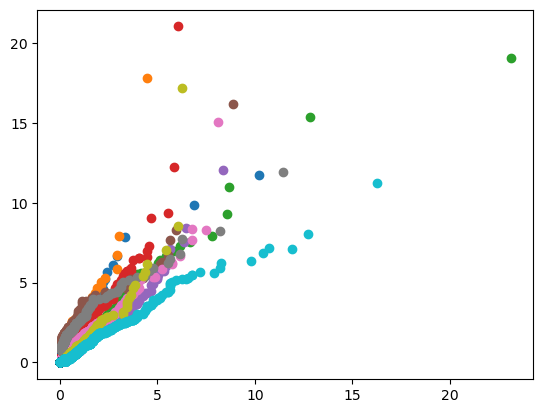

In [35]:
# Example of corrected pws
for i in range(10):
    plt.scatter(df_pws_pcp_hourly[pws_ids_accepted].iloc[:, i],
                df_pws_bias_corrected.iloc[:, i])

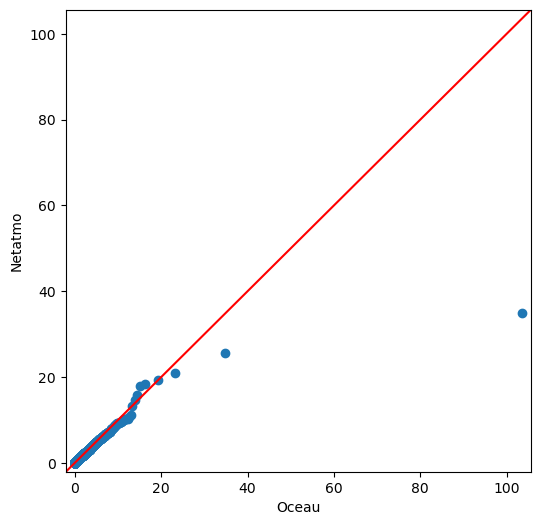

In [36]:
 
# convert to long (tidy) form
accepted_melt = accepted_pws.melt( var_name='station', value_name='vals')
primary_melt = in_primary_pcp.melt( var_name='station', value_name='vals')
funcs.QQplot(accepted_melt.vals.dropna(),primary_melt.vals.dropna(),50000)


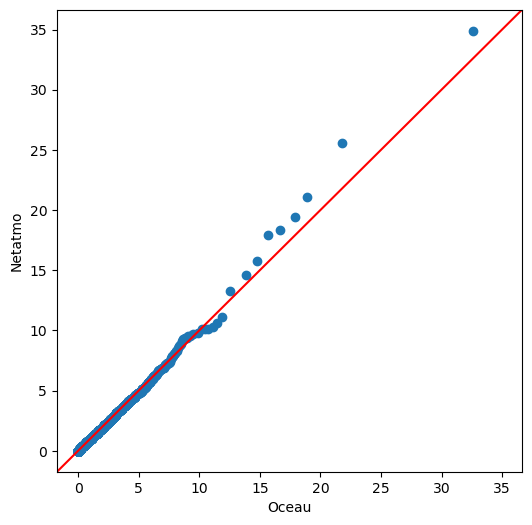

In [37]:
# convert to long (tidy) form
df_pws_bias_corrected_melt = df_pws_bias_corrected.melt( var_name='station', value_name='vals')
primary_melt = in_primary_pcp.melt( var_name='station', value_name='vals')
funcs.QQplot(df_pws_bias_corrected_melt.vals.dropna(),primary_melt.vals.dropna(),50000)

## 4. Apply On-Event filter 

The goal is to correct the PWS values (false zeros) and (false high values)
[Bárdossy et al. (2021)](https://doi.org/10.5194/hess-25-583-2021)

[El Hachem et at. (2022)](https://doi.org/10.5194/hess-26-6137-2022)

In [38]:
import PWSpyqcFunctions as pws_pyqc

In [39]:


df_pws_flagged = pws_pyqc.on_event_filter(df_pws=df_pws_bias_corrected, 
                               df_prim=in_primary_pcp, 
                               df_pws_coords=df_pws_coords,
                               df_prim_coords=df_prim_coords)

125it [00:00, 611.64it/s]

pws good 65
pws outlier 1
flaggind time step 2023-04-01 12:00:00
flagged values 0.097 min prim 0.0 max prim 0.7999999999999545
pws good 67
pws outlier 1
flaggind time step 2023-04-01 14:00:00
flagged values 0.101 min prim 0.0 max prim 0.2999999999999829
pws good 58
pws outlier 3
flaggind time step 2023-04-02 00:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
pws good 54
pws outlier 11
flaggind time step 2023-04-02 01:00:00
flagged values 0.101 min prim 0.0 max prim 0.4999999999999716
flaggind time step 2023-04-02 01:00:00
flagged values 0.101 min prim 0.0 max prim 0.4999999999999716
flaggind time step 2023-04-02 01:00:00
flagged values 0.101 min prim 0.0 max prim 0.4999999999999716


263it [00:00, 642.19it/s]

pws good 62
pws outlier 2
flaggind time step 2023-04-07 12:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-04-07 12:00:00
flagged values 1.211 min prim 0.0 max prim 0.1999999999999886
pws good 54
pws outlier 7
flaggind time step 2023-04-07 16:00:00
flagged values 0.176 min prim 0.0 max prim 0.8999999999999488
flaggind time step 2023-04-07 16:00:00
flagged values 0.101 min prim 0.0 max prim 0.8999999999999488
flaggind time step 2023-04-07 16:00:00
flagged values 0.101 min prim 0.0 max prim 0.8999999999999488
pws good 62
pws outlier 2
flaggind time step 2023-04-07 17:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-04-07 17:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
pws good 48
pws outlier 14
flaggind time step 2023-04-11 05:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-04-11 05:00:00
flagged values 0.991 min prim 0.0 max prim 0.199

392it [00:00, 603.62it/s]

pws good 63
pws outlier 1
pws good 52
pws outlier 7
flaggind time step 2023-04-13 18:00:00
flagged values 1.623 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-04-13 18:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
pws good 63
pws outlier 2
flaggind time step 2023-04-15 10:00:00
flagged values 0.101 min prim 0.0 max prim 0.8999999999999488
pws good 60
pws outlier 2


522it [00:00, 609.44it/s]

pws good 60
pws outlier 3
flaggind time step 2023-04-19 15:00:00
flagged values 2.093 min prim 0.0 max prim 0.4999999999999716
flaggind time step 2023-04-19 15:00:00
flagged values 1.775 min prim 0.0 max prim 0.4999999999999716
pws good 57
pws outlier 1
flaggind time step 2023-04-20 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.7999999999999545
pws good 60
pws outlier 2
flaggind time step 2023-04-20 09:00:00
flagged values 0.101 min prim 0.0 max prim 0.4999999999999716
pws good 63
pws outlier 2
pws good 56
pws outlier 7
flaggind time step 2023-04-21 05:00:00
flagged values 0.198 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-04-21 05:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-04-21 05:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-04-21 05:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-04-21 05:00:00
flagged values 0.101 mi

649it [00:01, 598.35it/s]

pws good 61
pws outlier 2
pws good 62
pws outlier 4
flaggind time step 2023-04-25 07:00:00
flagged values 0.101 min prim 0.0 max prim 2.499999999999858
flaggind time step 2023-04-25 07:00:00
flagged values 0.101 min prim 0.0 max prim 2.499999999999858
flaggind time step 2023-04-25 07:00:00
flagged values 0.101 min prim 0.0 max prim 2.499999999999858
pws good 63
pws outlier 1
flaggind time step 2023-04-25 10:00:00
flagged values 0.1 min prim 0.0 max prim 0.7999999999999545
pws good 56
pws outlier 4
flaggind time step 2023-04-29 13:00:00
flagged values 0.101 min prim 0.0 max prim 0.3999999999999772
flaggind time step 2023-04-29 13:00:00
flagged values 0.093 min prim 0.0 max prim 0.3999999999999772
flaggind time step 2023-04-29 13:00:00
flagged values 0.101 min prim 0.0 max prim 0.3999999999999772
flaggind time step 2023-04-29 13:00:00
flagged values 0.099 min prim 0.0 max prim 0.3999999999999772


848it [00:01, 632.61it/s]

pws good 52
pws outlier 7
flaggind time step 2023-05-01 05:00:00
flagged values 0.908 min prim 0.0 max prim 0.2999999999999829
flaggind time step 2023-05-01 05:00:00
flagged values 0.103 min prim 0.0 max prim 0.2999999999999829
flaggind time step 2023-05-01 05:00:00
flagged values 1.389 min prim 0.0 max prim 0.2999999999999829
flaggind time step 2023-05-01 05:00:00
flagged values 1.872 min prim 0.0 max prim 0.2999999999999829
pws good 63
pws outlier 5
flaggind time step 2023-05-01 13:00:00
flagged values 0.101 min prim 0.0 max prim 0.4999999999999716
pws good 57
pws outlier 2


912it [00:01, 611.45it/s]

pws good 46
pws outlier 2
flaggind time step 2023-05-07 04:00:00
flagged values 0.173 min prim 0.0 max prim 0.8999999999999488
pws good 52
pws outlier 1
flaggind time step 2023-05-07 05:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
pws good 62
pws outlier 2
flaggind time step 2023-05-07 12:00:00
flagged values 0.101 min prim 0.0 max prim 0.9999999999999432
flaggind time step 2023-05-07 12:00:00
flagged values 0.1 min prim 0.0 max prim 0.9999999999999432
pws good 49
pws outlier 9
flaggind time step 2023-05-09 22:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-05-09 22:00:00
flagged values 1.524 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-05-09 22:00:00
flagged values 1.211 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-05-09 22:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-05-09 22:00:00
flagged values 1.766 min prim 0.0 max prim 0.199999

1093it [00:01, 567.87it/s]

pws good 55
pws outlier 7
flaggind time step 2023-05-13 13:00:00
flagged values 0.105 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-05-13 13:00:00
flagged values 4.465 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-05-13 13:00:00
flagged values 1.891 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-05-13 13:00:00
flagged values 0.173 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-05-13 13:00:00
flagged values 1.036 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-05-13 13:00:00
flagged values 2.333 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-05-13 13:00:00
flagged values 0.654 min prim 0.0 max prim 0.1000000000000227
pws good 57
pws outlier 9
flaggind time step 2023-05-13 17:00:00
flagged values 1.447 min prim 0.0 max prim 0.4000000000000909
flaggind time step 2023-05-13 17:00:00
flagged values 1.652 min prim 0.0 max prim 0.4000000000000909
flaggind time step 2023-05-13 17:00:00


1297it [00:02, 622.36it/s]

pws good 54
pws outlier 1
pws good 62
pws outlier 1


1656it [00:02, 678.47it/s]

pws good 66
pws outlier 1
flaggind time step 2023-06-03 14:00:00
flagged values 1.159 min prim 0.0 max prim 0.1000000000000227
pws good 68
pws outlier 1
flaggind time step 2023-06-08 18:00:00
flagged values 3.605 min prim 0.0 max prim 0.4000000000000909


1724it [00:02, 636.24it/s]

pws good 65
pws outlier 1
flaggind time step 2023-06-09 15:00:00
flagged values 0.175 min prim 0.0 max prim 0.1000000000000227
pws good 61
pws outlier 3
flaggind time step 2023-06-09 17:00:00
flagged values 0.101 min prim 0.0 max prim 0.4000000000000909
pws good 50
pws outlier 7
flaggind time step 2023-06-09 19:00:00
flagged values 0.101 min prim 0.0 max prim 0.3999999999999772
flaggind time step 2023-06-09 19:00:00
flagged values 0.101 min prim 0.0 max prim 0.3999999999999772
flaggind time step 2023-06-09 19:00:00
flagged values 0.101 min prim 0.0 max prim 0.3999999999999772
pws good 52
pws outlier 1
pws good 56
pws outlier 2
flaggind time step 2023-06-10 04:00:00
flagged values 0.099 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-06-10 04:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 66
pws outlier 1
flaggind time step 2023-06-10 10:00:00
flagged values 0.101 min prim 0.0 max prim 0.9000000000002046
pws good 65
pws outlier 2
flaggind t

1983it [00:03, 588.28it/s]

pws good 59
pws outlier 1
pws good 57
pws outlier 1
flaggind time step 2023-06-19 22:00:00
flagged values 0.188 min prim 0.0 max prim 0.4000000000000909
pws good 52
pws outlier 1
flaggind time step 2023-06-19 23:00:00
flagged values 0.156 min prim 0.0 max prim 0.7000000000001592
pws good 57
pws outlier 1
flaggind time step 2023-06-21 14:00:00
flagged values 0.146 min prim 0.0 max prim 0.1000000000000227
pws good 52
pws outlier 4
flaggind time step 2023-06-22 18:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-06-22 18:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-06-22 18:00:00
flagged values 0.708 min prim 0.0 max prim 0.2000000000000454
pws good 53
pws outlier 2
flaggind time step 2023-06-23 00:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-06-23 00:00:00
flagged values 0.497 min prim 0.0 max prim 0.1000000000000227


2297it [00:03, 584.03it/s]

pws good 65
pws outlier 1
flaggind time step 2023-07-01 13:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 53
pws outlier 9
flaggind time step 2023-07-01 20:00:00
flagged values 2.285 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-07-01 20:00:00
flagged values 0.669 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-07-01 20:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-07-01 20:00:00
flagged values 1.183 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-07-01 20:00:00
flagged values 0.78 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-07-01 20:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999999886
flaggind time step 2023-07-01 20:00:00
flagged values 0.717 min prim 0.0 max prim 0.1999999999999886
pws good 60
pws outlier 1
flaggind time step 2023-07-02 06:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 65
pw

2430it [00:03, 608.30it/s]

pws good 62
pws outlier 1
pws good 62
pws outlier 8
flaggind time step 2023-07-11 16:00:00
flagged values 2.064 min prim 0.0 max prim 0.3999999999999772
flaggind time step 2023-07-11 16:00:00
flagged values 5.838 min prim 0.0 max prim 0.3999999999999772
flaggind time step 2023-07-11 16:00:00
flagged values 1.93 min prim 0.0 max prim 0.3999999999999772
flaggind time step 2023-07-11 16:00:00
flagged values 0.197 min prim 0.0 max prim 0.3999999999999772
pws good 54
pws outlier 3
flaggind time step 2023-07-11 23:00:00
flagged values 0.101 min prim 0.0 max prim 0.2999999999999829
pws good 51
pws outlier 2
flaggind time step 2023-07-12 00:00:00
flagged values 0.101 min prim 0.0 max prim 0.5000000000001137
flaggind time step 2023-07-12 00:00:00
flagged values 0.105 min prim 0.0 max prim 0.5000000000001137
pws good 56
pws outlier 4
flaggind time step 2023-07-12 04:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-12 04:00:00
flagged values 0.101 min

2614it [00:04, 494.04it/s]

pws good 64
pws outlier 1
flaggind time step 2023-07-15 11:00:00
flagged values 0.152 min prim 0.0 max prim 0.2000000000000454
pws good 51
pws outlier 4
flaggind time step 2023-07-15 19:00:00
flagged values 2.159 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-15 19:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-15 19:00:00
flagged values 0.501 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-15 19:00:00
flagged values 0.475 min prim 0.0 max prim 0.1000000000000227
pws good 55
pws outlier 8
flaggind time step 2023-07-16 00:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-16 00:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-16 00:00:00
flagged values 0.303 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-16 00:00:00
flagged values 0.18 min prim 0.0 max prim 0.1000000000000227
flaggind time 

2746it [00:04, 550.56it/s]

pws good 64
pws outlier 1
flaggind time step 2023-07-19 09:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 57
pws outlier 9
flaggind time step 2023-07-21 07:00:00
flagged values 0.102 min prim 0.0 max prim 1.3000000000002956
pws good 69
pws outlier 1
flaggind time step 2023-07-21 08:00:00
flagged values 0.101 min prim 0.0 max prim 0.9000000000002046
pws good 63
pws outlier 1
pws good 60
pws outlier 3
flaggind time step 2023-07-24 05:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 62
pws outlier 2
flaggind time step 2023-07-24 08:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-07-24 08:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
pws good 60
pws outlier 3
flaggind time step 2023-07-24 09:00:00
flagged values 0.098 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-24 09:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind t

2866it [00:04, 561.56it/s]

pws good 62
pws outlier 1
flaggind time step 2023-07-24 21:00:00
flagged values 0.175 min prim 0.0 max prim 25.39999999999856
pws good 61
pws outlier 11
flaggind time step 2023-07-25 09:00:00
flagged values 0.12 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-07-25 09:00:00
flagged values 0.097 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-07-25 09:00:00
flagged values 0.1 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-07-25 09:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-07-25 09:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-07-25 09:00:00
flagged values 0.783 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-07-25 09:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-07-25 09:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
pws good 62
pws outlier 3
pws good 72
pws 

2930it [00:04, 575.21it/s]

pws good 65
pws outlier 1
flaggind time step 2023-07-29 19:00:00
flagged values 0.101 min prim 0.0 max prim 0.6000000000001364
pws good 63
pws outlier 1
flaggind time step 2023-07-29 23:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 65
pws outlier 1
flaggind time step 2023-07-30 02:00:00
flagged values 0.101 min prim 0.0 max prim 2.300000000000523
pws good 66
pws outlier 5
flaggind time step 2023-07-30 06:00:00
flagged values 0.536 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-30 06:00:00
flagged values 1.119 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-30 06:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-07-30 06:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 62
pws outlier 1
flaggind time step 2023-07-30 10:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 66
pws outlier 5
flaggind time step 2023-08-01 14:00:0

3106it [00:05, 555.05it/s]

pws good 63
pws outlier 2
flaggind time step 2023-08-04 16:00:00
flagged values 0.515 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-04 16:00:00
flagged values 0.782 min prim 0.0 max prim 0.1000000000000227
pws good 66
pws outlier 1
flaggind time step 2023-08-04 17:00:00
flagged values 1.115 min prim 0.0 max prim 0.1000000000000227
pws good 53
pws outlier 13
flaggind time step 2023-08-05 01:00:00
flagged values 1.802 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-05 01:00:00
flagged values 0.312 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-05 01:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-05 01:00:00
flagged values 0.412 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-05 01:00:00
flagged values 1.499 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-05 01:00:00
flagged values 0.61 min prim 0.0 max prim 0.1000000000000227
flaggind time

3318it [00:05, 630.99it/s]

pws good 62
pws outlier 5
flaggind time step 2023-08-13 20:00:00
flagged values 0.197 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-08-13 20:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-08-13 20:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-08-13 20:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-08-13 20:00:00
flagged values 0.097 min prim 0.0 max prim 0.2000000000000454
pws good 58
pws outlier 1
flaggind time step 2023-08-13 22:00:00
flagged values 0.468 min prim 0.0 max prim 0.1000000000000227


3591it [00:06, 573.58it/s]

pws good 65
pws outlier 3
flaggind time step 2023-08-25 17:00:00
flagged values 0.099 min prim 0.0 max prim 0.3000000000000682
flaggind time step 2023-08-25 17:00:00
flagged values 1.009 min prim 0.0 max prim 0.3000000000000682
pws good 59
pws outlier 11
flaggind time step 2023-08-25 21:00:00
flagged values 0.133 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-25 21:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-25 21:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-25 21:00:00
flagged values 0.192 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-25 21:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-25 21:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-25 21:00:00
flagged values 0.1 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-25 21:00:00
f

3718it [00:06, 573.76it/s]

pws good 62
pws outlier 2
flaggind time step 2023-08-29 17:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-08-29 17:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 66
pws outlier 1
flaggind time step 2023-08-30 11:00:00
flagged values 0.743 min prim 0.0 max prim 0.1000000000000227


4005it [00:06, 612.37it/s]

pws good 60
pws outlier 1
flaggind time step 2023-09-13 00:00:00
flagged values 0.197 min prim 0.0 max prim 0.3000000000000682
pws good 57
pws outlier 5
flaggind time step 2023-09-13 01:00:00
flagged values 5.087 min prim 0.0 max prim 1.500000000000341
flaggind time step 2023-09-13 01:00:00
flagged values 0.19 min prim 0.0 max prim 1.500000000000341
flaggind time step 2023-09-13 01:00:00
flagged values 0.096 min prim 0.0 max prim 1.500000000000341
pws good 56
pws outlier 2
flaggind time step 2023-09-13 03:00:00
flagged values 0.101 min prim 0.0 max prim 0.3000000000000682
pws good 53
pws outlier 9
flaggind time step 2023-09-13 06:00:00
flagged values 0.89 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-09-13 06:00:00
flagged values 0.669 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-09-13 06:00:00
flagged values 2.367 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-09-13 06:00:00
flagged values 0.101 min prim 0.0 max prim 0.200000000

4131it [00:06, 575.03it/s]

pws good 61
pws outlier 1
flaggind time step 2023-09-17 21:00:00
flagged values 0.101 min prim 0.0 max prim 0.3000000000000682
pws good 59
pws outlier 2
pws good 70
pws outlier 1
flaggind time step 2023-09-18 15:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 65
pws outlier 4
flaggind time step 2023-09-18 16:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-09-18 16:00:00
flagged values 0.098 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-09-18 16:00:00
flagged values 2.136 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-09-18 16:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 64
pws outlier 1
pws good 59
pws outlier 4
flaggind time step 2023-09-19 00:00:00
flagged values 0.101 min prim 0.0 max prim 0.3000000000000682
flaggind time step 2023-09-19 00:00:00
flagged values 0.101 min prim 0.0 max prim 0.3000000000000682
flaggind time step 2023-09-19 00:00:

4253it [00:07, 562.40it/s]

pws good 68
pws outlier 3
flaggind time step 2023-09-22 08:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-09-22 08:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-09-22 08:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 63
pws outlier 2
flaggind time step 2023-09-22 10:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-09-22 10:00:00
flagged values 0.121 min prim 0.0 max prim 0.1000000000000227
pws good 61
pws outlier 2
flaggind time step 2023-09-22 23:00:00
flagged values 0.141 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-09-22 23:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 63
pws outlier 1
flaggind time step 2023-09-23 03:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 62
pws outlier 2
flaggind time step 2023-09-23 04:00:00
flagged values 0.101 mi

4543it [00:07, 657.05it/s]

pws good 60
pws outlier 9
flaggind time step 2023-10-03 16:00:00
flagged values 2.951 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-03 16:00:00
flagged values 5.034 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-03 16:00:00
flagged values 12.47 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-03 16:00:00
flagged values 7.753 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-03 16:00:00
flagged values 11.003 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-03 16:00:00
flagged values 1.045 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-03 16:00:00
flagged values 9.598 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-03 16:00:00
flagged values 0.098 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-03 16:00:00
flagged values 0.099 min prim 0.0 max prim 0.2000000000000454
pws good 60
pws outlier 1
flaggind time step 2023-10-06 06:00:00

4753it [00:07, 648.74it/s]

pws good 62
pws outlier 5
flaggind time step 2023-10-14 00:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-14 00:00:00
flagged values 0.946 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-14 00:00:00
flagged values 0.545 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-14 00:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 63
pws outlier 1
flaggind time step 2023-10-14 06:00:00
flagged values 0.101 min prim 0.0 max prim 0.7000000000001592
pws good 68
pws outlier 1
flaggind time step 2023-10-14 10:00:00
flagged values 0.101 min prim 0.0 max prim 0.6000000000001364
pws good 65
pws outlier 1
flaggind time step 2023-10-14 11:00:00
flagged values 0.099 min prim 0.0 max prim 3.000000000000682
pws good 59
pws outlier 6
flaggind time step 2023-10-14 15:00:00
flagged values 2.474 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-14 15:00:00
flagged values 6.013 min

4884it [00:08, 581.57it/s]

pws good 64
pws outlier 1
flaggind time step 2023-10-19 10:00:00
flagged values 0.102 min prim 0.0 max prim 0.2000000000000454
pws good 65
pws outlier 2
flaggind time step 2023-10-19 11:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-19 11:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 61
pws outlier 3
flaggind time step 2023-10-19 17:00:00
flagged values 0.75 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-19 17:00:00
flagged values 0.168 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-19 17:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 57
pws outlier 1
flaggind time step 2023-10-20 12:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 57
pws outlier 4
flaggind time step 2023-10-20 21:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-20 21:00:00
flagged values 0.101 min

5002it [00:08, 517.42it/s]

pws good 64
pws outlier 2
flaggind time step 2023-10-23 20:00:00
flagged values 0.101 min prim 0.0 max prim 0.4000000000000909
pws good 49
pws outlier 13
flaggind time step 2023-10-24 02:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-24 02:00:00
flagged values 0.303 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-24 02:00:00
flagged values 0.303 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-24 02:00:00
flagged values 0.384 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-24 02:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-24 02:00:00
flagged values 0.145 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-24 02:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-24 02:00:00
flagged values 1.527 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-24 02:00:00

5110it [00:08, 501.67it/s]

pws good 59
pws outlier 2
flaggind time step 2023-10-27 08:00:00
flagged values 0.402 min prim 0.0 max prim 0.1000000000000227
pws good 60
pws outlier 6
flaggind time step 2023-10-27 09:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-27 09:00:00
flagged values 0.185 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-27 09:00:00
flagged values 0.193 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-27 09:00:00
flagged values 0.14 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-10-27 09:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
pws good 59
pws outlier 3
flaggind time step 2023-10-27 10:00:00
flagged values 0.711 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-10-27 10:00:00
flagged values 0.366 min prim 0.0 max prim 0.1000000000000227
pws good 67
pws outlier 2
flaggind time step 2023-10-27 11:00:00
flagged values 0.1 min prim 0.0 max prim 0.2000000

5212it [00:08, 463.58it/s]

pws good 56
pws outlier 2
flaggind time step 2023-11-01 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-01 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 61
pws outlier 1
flaggind time step 2023-11-01 17:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 58
pws outlier 4
flaggind time step 2023-11-02 03:00:00
flagged values 0.109 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-02 03:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-02 03:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-02 03:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 61
pws outlier 1
flaggind time step 2023-11-02 05:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 52
pws outlier 11
flaggind time step 2023-11-02 18:00:00
flagged values 0.411 m

5317it [00:09, 470.73it/s]

pws good 56
pws outlier 1
flaggind time step 2023-11-05 02:00:00
flagged values 0.095 min prim 0.0 max prim 0.9000000000002046
pws good 57
pws outlier 3
flaggind time step 2023-11-05 04:00:00
flagged values 0.101 min prim 0.0 max prim 0.6000000000001364
flaggind time step 2023-11-05 04:00:00
flagged values 0.101 min prim 0.0 max prim 0.6000000000001364
pws good 60
pws outlier 2
flaggind time step 2023-11-05 05:00:00
flagged values 0.101 min prim 0.0 max prim 1.2000000000002728
pws good 61
pws outlier 3
flaggind time step 2023-11-05 15:00:00
flagged values 0.794 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-05 15:00:00
flagged values 0.689 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-05 15:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 51
pws outlier 12
flaggind time step 2023-11-05 17:00:00
flagged values 0.101 min prim 0.0 max prim 0.5000000000001137
flaggind time step 2023-11-05 17:00:00
flagged values 0.101 m

5412it [00:09, 435.23it/s]

pws good 59
pws outlier 1
flaggind time step 2023-11-09 22:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
pws good 62
pws outlier 1
flaggind time step 2023-11-10 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.3000000000000682
pws good 63
pws outlier 3
flaggind time step 2023-11-10 11:00:00
flagged values 0.432 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-10 11:00:00
flagged values 0.622 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-10 11:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 67
pws outlier 2
flaggind time step 2023-11-10 15:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-10 15:00:00
flagged values 0.613 min prim 0.0 max prim 0.1000000000000227
pws good 65
pws outlier 1
pws good 63
pws outlier 2
flaggind time step 2023-11-10 21:00:00
flagged values 0.101 min prim 0.0 max prim 0.6000000000001364
flaggind time step 2023-11-10 21:00:

5509it [00:09, 437.91it/s]

pws good 62
pws outlier 3
flaggind time step 2023-11-13 07:00:00
flagged values 0.16 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-13 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-13 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 64
pws outlier 3
flaggind time step 2023-11-13 17:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-13 17:00:00
flagged values 0.171 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-13 17:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 60
pws outlier 6
flaggind time step 2023-11-13 19:00:00
flagged values 0.468 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-13 19:00:00
flagged values 0.462 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-13 19:00:00
flagged values 0.102 min prim 0.0 max prim 0.1000000000000227
pws good 64
pw

5619it [00:09, 476.44it/s]

pws good 58
pws outlier 5
flaggind time step 2023-11-16 22:00:00
flagged values 0.1 min prim 0.0 max prim 0.7000000000001592
flaggind time step 2023-11-16 22:00:00
flagged values 0.099 min prim 0.0 max prim 0.7000000000001592
flaggind time step 2023-11-16 22:00:00
flagged values 0.151 min prim 0.0 max prim 0.7000000000001592
pws good 59
pws outlier 2
flaggind time step 2023-11-16 23:00:00
flagged values 0.197 min prim 0.0 max prim 0.3000000000000682
flaggind time step 2023-11-16 23:00:00
flagged values 0.099 min prim 0.0 max prim 0.3000000000000682
pws good 55
pws outlier 7
flaggind time step 2023-11-17 00:00:00
flagged values 0.101 min prim 0.0 max prim 0.7000000000001592
pws good 60
pws outlier 4
flaggind time step 2023-11-17 01:00:00
flagged values 0.101 min prim 0.0 max prim 0.3000000000000682
flaggind time step 2023-11-17 01:00:00
flagged values 0.101 min prim 0.0 max prim 0.3000000000000682
flaggind time step 2023-11-17 01:00:00
flagged values 0.101 min prim 0.0 max prim 0.300000

5760it [00:09, 569.58it/s]

pws good 63
pws outlier 2
flaggind time step 2023-11-21 12:00:00
flagged values 0.198 min prim 0.0 max prim 1.0000000000002274
pws good 68
pws outlier 1
pws good 63
pws outlier 1
pws good 66
pws outlier 4
flaggind time step 2023-11-25 11:00:00
flagged values 0.339 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-11-25 11:00:00
flagged values 0.411 min prim 0.0 max prim 0.1000000000000227


5818it [00:10, 551.76it/s]

pws good 63
pws outlier 2
flaggind time step 2023-11-27 15:00:00
flagged values 0.171 min prim 0.0 max prim 0.3000000000000682
pws good 64
pws outlier 1
flaggind time step 2023-11-28 02:00:00
flagged values 0.101 min prim 0.0 max prim 0.4000000000000909
pws good 61
pws outlier 2
flaggind time step 2023-11-28 09:00:00
flagged values 0.1 min prim 0.0 max prim 0.4000000000000909
flaggind time step 2023-11-28 09:00:00
flagged values 0.099 min prim 0.0 max prim 0.4000000000000909
pws good 63
pws outlier 5
flaggind time step 2023-11-28 10:00:00
flagged values 6.747 min prim 0.0 max prim 0.3000000000000682
flaggind time step 2023-11-28 10:00:00
flagged values 1.769 min prim 0.0 max prim 0.3000000000000682
pws good 64
pws outlier 1
pws good 70
pws outlier 1


6010it [00:10, 505.39it/s]

pws good 68
pws outlier 1
flaggind time step 2023-12-02 04:00:00
flagged values 0.101 min prim 0.0 max prim 0.4000000000000909
pws good 64
pws outlier 1
flaggind time step 2023-12-02 05:00:00
flagged values 0.101 min prim 0.0 max prim 0.5000000000001137
pws good 43
pws outlier 19
flaggind time step 2023-12-02 06:00:00
flagged values 0.305 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-02 06:00:00
flagged values 0.401 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-02 06:00:00
flagged values 0.387 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-02 06:00:00
flagged values 0.493 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-02 06:00:00
flagged values 0.155 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-02 06:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-02 06:00:00
flagged values 0.099 min prim 0.0 max prim 0.1000000000000227
flaggind tim

6179it [00:10, 454.01it/s]

pws good 58
pws outlier 6
flaggind time step 2023-12-13 01:00:00
flagged values 0.538 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-13 01:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-13 01:00:00
flagged values 0.504 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-13 01:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-13 01:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 61
pws outlier 3
flaggind time step 2023-12-13 10:00:00
flagged values 0.362 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-13 10:00:00
flagged values 0.303 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-13 10:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 63
pws outlier 1
flaggind time step 2023-12-13 11:00:00
flagged values 18.213 min prim 0.0 max prim 0.2999999999997271
pws good 58


6378it [00:11, 518.42it/s]

pws good 58
pws outlier 3
flaggind time step 2023-12-19 11:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999998181
flaggind time step 2023-12-19 11:00:00
flagged values 0.101 min prim 0.0 max prim 0.1999999999998181
pws good 51
pws outlier 6
flaggind time step 2023-12-20 03:00:00
flagged values 0.101 min prim 0.0 max prim 0.4999999999995452
flaggind time step 2023-12-20 03:00:00
flagged values 0.137 min prim 0.0 max prim 0.4999999999995452
flaggind time step 2023-12-20 03:00:00
flagged values 0.101 min prim 0.0 max prim 0.4999999999995452
flaggind time step 2023-12-20 03:00:00
flagged values 0.101 min prim 0.0 max prim 0.4999999999995452
pws good 60
pws outlier 2
flaggind time step 2023-12-20 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
flaggind time step 2023-12-20 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.1000000000000227
pws good 49
pws outlier 8
flaggind time step 2023-12-20 09:00:00
flagged values 0.128 min prim 0.0 max prim 0.1000

6591it [00:11, 566.91it/s]

pws good 56
pws outlier 2
flaggind time step 2023-12-29 05:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-12-29 05:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
pws good 55
pws outlier 1
pws good 60
pws outlier 4
flaggind time step 2023-12-29 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-12-29 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-12-29 07:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
pws good 56
pws outlier 6
flaggind time step 2023-12-29 15:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-12-29 15:00:00
flagged values 0.171 min prim 0.0 max prim 0.2000000000000454
flaggind time step 2023-12-29 15:00:00
flagged values 0.101 min prim 0.0 max prim 0.2000000000000454
pws good 61
pws outlier 1
flaggind time step 2023-12-29 17:00:00
flagged values 0.101 mi

## Exporting csv

In [40]:
df_pws_flagged.to_csv('Data/Output_algo_2/flagged_csv.csv') 
accepted_pws.to_csv('Data/Output_algo_2/netatmo_accepted.csv')
df_pws_bias_corrected.to_csv('Data/Output_algo_2/bias_corrected.csv')
df_pws_flagged.to_csv('Data/Output_algo_2/flagged_csv_after_modif.csv') 

Une analyse plus détaillée est effectuée est effectuée dans analyses/Data_analyses

In [41]:
df_pws_flagged.size

652509

In [42]:
nb_nan_pws_bias_corrected = df_pws_bias_corrected.isna().sum().sum()
nb_nan_pws_flagged = df_pws_flagged.isna().sum().sum()

print(f'The number of nans in pws_bias_corrected is  {nb_nan_pws_bias_corrected}')
print(f'The number of nans once flagged is {nb_nan_pws_flagged}')
print(f'Thus the number of removed values with the event bias filtering is {nb_nan_pws_flagged - nb_nan_pws_bias_corrected}')

The number of nans in pws_bias_corrected is  255512
The number of nans once flagged is 256406
Thus the number of removed values with the event bias filtering is 894


In [43]:
nb_nan_pws_bias_corrected = df_pws_bias_corrected.isna().sum().sum()
nb_nan_pws_flagged = df_pws_flagged.isna().sum().sum()

print(f'The number of nans in pws_bias_corrected is  {nb_nan_pws_bias_corrected}')
print(f'The number of nans once flagged is {nb_nan_pws_flagged}')
print(f'Thus the number of removed values with the event bias filtering is {nb_nan_pws_flagged - nb_nan_pws_bias_corrected}')

The number of nans in pws_bias_corrected is  255512
The number of nans once flagged is 256406
Thus the number of removed values with the event bias filtering is 894


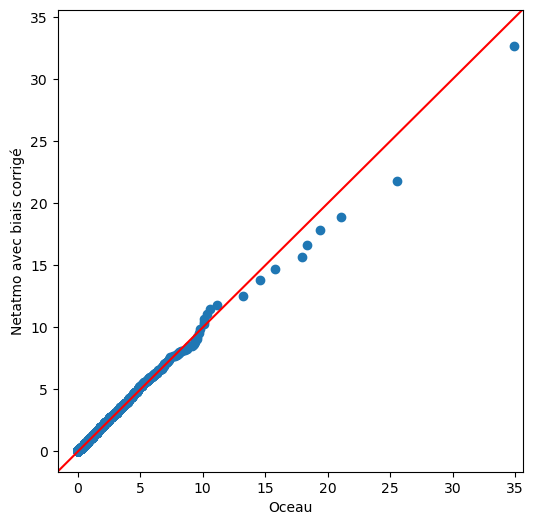

In [44]:
# convert to long (tidy) form
df_pws_bias_corrected_melt = df_pws_bias_corrected.melt( var_name='station', value_name='vals')
primary_melt = in_primary_pcp.melt( var_name='station', value_name='vals')
funcs.QQplot(primary_melt.vals.dropna(),df_pws_bias_corrected_melt.vals.dropna(),50000,label_2_sample = "Netatmo avec biais corrigé")

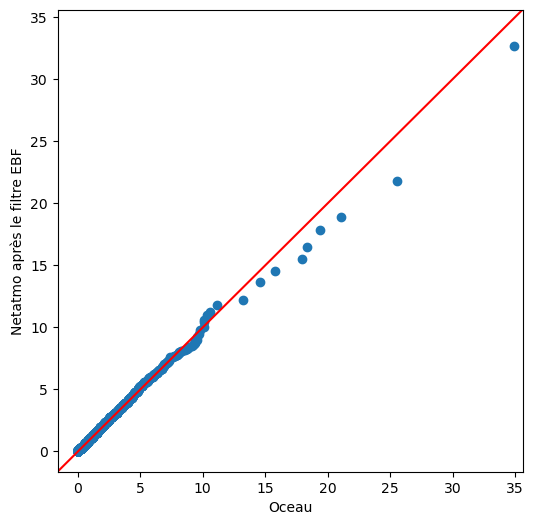

In [45]:
# convert to long (tidy) form
df_pws_flagged_melt = df_pws_flagged.melt( var_name='station', value_name='vals')
primary_melt = in_primary_pcp.melt( var_name='station', value_name='vals')
funcs.QQplot(primary_melt.vals.dropna(),df_pws_flagged_melt.vals.dropna(),50000,label_2_sample = "Netatmo après le filtre EBF")

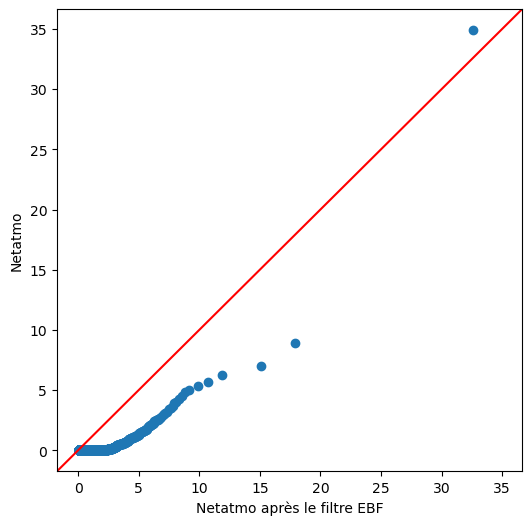

In [46]:
# convert to long (tidy) form
df_pws_flagged_melt = df_pws_flagged.melt( var_name='station', value_name='vals')
df_pws_flagged_melt_without_0 = df_pws_flagged_melt[df_pws_flagged_melt.vals>0]
primary_melt = in_primary_pcp.melt( var_name='station', value_name='vals')
primary_melt_without_0 = primary_melt[primary_melt.vals>0]
funcs.QQplot(df_pws_flagged_melt_without_0.vals.dropna(),primary_melt.vals.dropna(),2000,label_1_sample = "Netatmo après le filtre EBF")

In [47]:

print(f"Le pourcentage de 0 dans les stations avec correction de biais est: {funcs.compute_0_percent(df_pws_bias_corrected_melt.vals.dropna())}")
print(f"le pourcentage de nan des stations avec correction de biais est: {df_pws_bias_corrected_melt.vals.isna().sum()/df_pws_bias_corrected_melt.vals.shape[0]}")
df_pws_bias_corrected_melt.describe()

Le pourcentage de 0 dans les stations avec correction de biais est: 0.8822963397708296
le pourcentage de nan des stations avec correction de biais est: 0.3915838708738117


vals
count  396997.000000
mean        0.124400
std         0.616465
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        32.638000